# How to Create ARIMA Model Forecasting BTCUSD in Python Part 1

In my previous posts, we have discussed [stationarity tests](https://0xboz.github.io/blog/how-to-run-stationarity-tests-on-cryptocurrencies-trading-data/) on crypto trading data. In this upcoming series, we are going to explore how to implement Autoregressive Integrated Moving Average Model (ARIMA) into our crypto quantitative analysis.

<div class="notice--danger">
  <p>The following material is for educational purposes only. Do NOT use it in production or bid with real money.</p>
</div>

## ARIMA
ARIMA is a general class of statistical models for analyzing and forecasting time series data. It includes [random walk](https://en.wikipedia.org/wiki/Random_walk), [moving average](https://en.wikipedia.org/wiki/Moving-average_model), seasonal and non-seasonal [exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) and [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model). One of the good places to start learning the fundamental theory is [Prof. Nau's course notes and materials](http://people.duke.edu/~rnau/411home.htm), which provides a deep dive into time series analysis, explaining every aspect in detail.

## BTCUSD Trading Data
Again, we are using [Catalyst](https://enigma.co/catalyst/) to pull out BTCUSD trading data from 2015-3-3 to 2019-6-25. In your terminal, run this command to ingest the data we need for this post.
```
(venv) catalyst ingest-exchange -x bitfinex -f daily -i btc_usd
```
If you haven't installed Catalyst yet, take a look at [this post](https://0xboz.github.io/blog/how-to-install-catalyst-debian-stretch/) and come back later.

Great! Let us create a new file named ```ARIMA.ipynb``` with [JuypterLab](https://jupyterlab.readthedocs.io/en/stable/) or [Juypter Notebook](https://jupyter.org/). Add the following code and hit ```Shift + Enter```

```python
%matplotlib inline
# Increase chart resolution
%config InlineBackend.figure_format = 'retina'

from catalyst.api import symbol, record
from catalyst import run_algorithm

from datetime import timedelta

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import style
from matplotlib import ticker

import numpy as np
import pandas as pd

from scipy import stats
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

trading_pair = 'btc_usd'
frequency = 'daily'
exchange = 'bitfinex'
start = '2015-3-3'
end = '2019-6-25'
capital_base = 1000
quote_currency = trading_pair.split('_')[1]

def initialize(context):
    context.asset = symbol(trading_pair)

def handle_data(context, data):
    
    # The last known price and volume of current date/minute and the day/minute before
    if frequency == 'daily':        
        price = data.current(context.asset, 'price')
        volume = data.current(context.asset, 'volume')
    elif frequency == 'minute':        
        price = data.current(context.asset, 'price')
        volume = data.current(context.asset, 'volume')

    record(price=price, volume=volume)
  
if __name__ == '__main__':   
    perf = run_algorithm(capital_base=capital_base,
                         data_frequency=frequency,
                         initialize=initialize,
                         handle_data=handle_data,                      
                         exchange_name=exchange,
                         quote_currency=quote_currency,
                         start=pd.to_datetime(start, utc=True),
                         end=pd.to_datetime(end, utc=True))
```

In [74]:
%matplotlib inline
# Increase chart resolution
%config InlineBackend.figure_format = 'retina'

from catalyst.api import symbol, record
from catalyst import run_algorithm

from datetime import timedelta

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import style
from matplotlib import ticker

import numpy as np
import pandas as pd

from scipy import stats
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

trading_pair = 'btc_usd'
frequency = 'daily'
exchange = 'bitfinex'
start = '2015-3-3'
end = '2019-6-25'
capital_base = 1000
quote_currency = trading_pair.split('_')[1]

def initialize(context):
    context.asset = symbol(trading_pair)

def handle_data(context, data):
    
    # The last known price and volume of current date/minute and the day/minute before
    if frequency == 'daily':        
        price = data.current(context.asset, 'price')
        volume = data.current(context.asset, 'volume')
    elif frequency == 'minute':        
        price = data.current(context.asset, 'price')
        volume = data.current(context.asset, 'volume')

    record(price=price, volume=volume)
  
if __name__ == '__main__':   
    perf = run_algorithm(capital_base=capital_base,
                         data_frequency=frequency,
                         initialize=initialize,
                         handle_data=handle_data,                      
                         exchange_name=exchange,
                         quote_currency=quote_currency,
                         start=pd.to_datetime(start, utc=True),
                         end=pd.to_datetime(end, utc=True))

[2019-07-05 20:00:51.731813] INFO: run_algo: Catalyst version 0.5.21
[2019-07-05 20:00:51.732379] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-07-05 20:00:54.735994] INFO: run_algo: running algo in backtest mode
[2019-07-05 20:00:54.743170] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2019-07-05 20:00:57.156772] INFO: Performance: Simulated 1576 trading days out of 1576.
[2019-07-05 20:00:57.157167] INFO: Performance: first open: 2015-03-03 00:00:00+00:00
[2019-07-05 20:00:57.157519] INFO: Performance: last close: 2019-06-25 23:59:00+00:00


The daily (close) price and volume are stored in ```perf``` (performance). Let us resample our data into daily, weekly, bi-weekly and monthly data sets.
```python
# Daily data
d_df = pd.DataFrame(perf.loc[:, ['price', 'volume']], index=perf.index).resample('1d').mean().round(2).copy()

# Weekly data
w_df = d_df.resample('1w').mean().round(2).copy()

# Bi-weekly data
bw_df = d_df.resample('2w').mean().round(2).copy()

# Monthly data
m_df = d_df.resample('1M').mean().round(2).copy()

df_list = [d_df, w_df, bw_df, m_df]
```

In [2]:
# Daily data
d_df = pd.DataFrame(perf.loc[:, ['price', 'volume']], index=perf.index).resample('1d').mean().round(2).copy()

# Weekly data
w_df = d_df.resample('1w').mean().round(2).copy()

# Bi-weekly data
bw_df = d_df.resample('2w').mean().round(2).copy()

# Monthly data
m_df = d_df.resample('1M').mean().round(2).copy()

df_list = [d_df, w_df, bw_df, m_df]

## Logarithmic Price Chart
You might be curious about what they look like. Remember the [logarithmic price scale](https://www.investopedia.com/terms/l/logarithmicscale.asp) discussed in [my previous post](https://0xboz.github.io/blog/how-to-create-bitcoin-logarithmic-price-scale-using-matplotlib/)? We can create a similar function and take a quick look at what we have from the resampling.

Further, we are going to use this very same function to compare our forecast with history price at the end of this series. It is totally okay if you can not understand some parts of this function at the moment. I will do my best to explain them in detail.

```python
def make_log_price_chart(df, frequency='Daily'):
    """
    Plot in logarithmic price scale
    """
    sns.set(style="ticks")
    fig_log_price = plt.figure(figsize=(26,7))
```

We are going to use seaborn ticks style. I have set up the figure size based on my screen. Feel free to change it to your liking. In case you need to install seaborn, run this command in the terminal
```
(venv) pip install -U seachborn
```

Now we need to check the data frequency once the function has taken in the panda dataframe, and we are going to use this frequency information to plot the figure accordingly.
```python
    # Data Frequency
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
```

Let us create the first subplot for the price data.
```python
    # History Price
    ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
```

If there is only history price, we are going to use line chart. At the end of this series, the data frame will contain forecast as well. In that case, the function uses scatter chart to plot the history price instead.
```python
    if 'forecast' in df.columns:    
        ax1.semilogy(df.index, df.price, basey=10, color='k', linewidth=0, marker='.')
        lg_price = mlines.Line2D([], [], color='k', label='BTCUSD History', linewidth=0, marker='.')
        
    else:
        ax1.semilogy(df.index, df.price, basey=10, color='k', linewidth=0.75)
        lg_price = mlines.Line2D([], [], color='k', label='BTCUSD History', linewidth=1.5)
```

More format tweeks for the price chart.
```python
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.set_ylim([np.min(perf.price) * 0.9, np.max(perf.price) * 1.1])
    plt.ylabel('Log Price', fontsize=12)
    ax1.tick_params(axis='y', which='both', labelsize=8)
    plt.grid(which='minor')
    plt.xticks(fontsize=12, rotation=0)
```

Now, we can work on the second subplot - volume.
```python
    # Volume in Log Price Chart
    ax1v = ax1.twinx()
    ax1v.set_ylim([0, np.max(perf.volume) * 2])
    ax1v.fill_between(df.index, df.volume, color='#F89E38', alpha=0.4, label='2')
    plt.grid(False)
    plt.setp(ax1v.get_yticklabels(), visible=False)
    lg_volume = mpatches.Patch(color='#F89E38', label='Volume', alpha=0.4)
```

Here comes the forecast part. We will show the last forecast price on the right in a annotation green box. In case of history price only, the chart presents the last known price in a white box. In addition, the 95% confidence interval (upper & lower) will be plotted in red.
```python
    if 'forecast' in df.columns:
        
        # Forecast Price
        ax1.semilogy(df.index, df.forecast, basey=10, color='g', linewidth=0.75)
        
        # Forecast Price Annotation
        bbox_props = dict(boxstyle='round',fc='g', ec='k',lw=0.25)
        last_forecast_price_date = df.forecast.last_valid_index()
        last_forecast_price_index = df.index.get_loc(last_forecast_price_date)
        last_forecast_price = df.forecast.iloc[last_forecast_price_index]
        ax1.annotate(str(last_forecast_price), (last_forecast_price_date, last_forecast_price),
                    xytext = (last_forecast_price_date + pd.Timedelta('7d'), last_forecast_price), 
                    bbox=bbox_props, fontsize=10)
        
        # Plot confidence interval
        first_forecast_price_date = df.forecast.first_valid_index()        
        first_forecast_price_index = df.index.get_loc(first_forecast_price_date)        
        ax1.fill_between(df.index[first_forecast_price_index:], 
                         df['upper forecast'].iloc[first_forecast_price_index:], 
                         df['lower forecast'].iloc[first_forecast_price_index:], 
                         color='r', 
                         alpha=0.2)
        
        ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
        ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
        
        lg_forecast = mlines.Line2D([], [], color='g', label='BTCUSD Forecast', linewidth=1.5)
        lg_forecast_ci = mpatches.Patch(color='r', label='95% Confidence Interval', alpha=0.2)
        plt.legend(handles=[lg_price, lg_forecast, lg_volume, lg_forecast_ci], loc='center right')
    else:
        # History Price Annotation
        bbox_props = dict(boxstyle='round',fc='w', ec='k', lw=0.25)
        last_known_price_date = df.price.last_valid_index()
        last_known_price_index = df.index.get_loc(last_known_price_date)
        last_known_price = df.price.iloc[last_known_price_index]
        ax1.annotate(str(last_known_price), (last_known_price_date, last_known_price),
                    xytext = (last_known_price_date + pd.Timedelta('14d'), last_known_price), 
                    bbox=bbox_props, fontsize=10)
        plt.legend(handles=[lg_price, lg_volume], loc='center right')
```

Put everything together for ```make_log_price_chart()```, and we have got the following.
```python
def make_log_price_chart(df, frequency='Daily'):
    """
    Plot in logarithmic price scale
    """
    sns.set(style="ticks")
    fig_log_price = plt.figure(figsize=(26,7))
    
    # Data Frequency
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    
    # History Price
    ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
    
    if 'forecast' in df.columns:    
        ax1.semilogy(df.index, df.price, basey=10, color='k', linewidth=0, marker='.')
        lg_price = mlines.Line2D([], [], color='k', label='BTCUSD History', linewidth=0, marker='.')
        
    else:
        ax1.semilogy(df.index, df.price, basey=10, color='k', linewidth=0.75)
        lg_price = mlines.Line2D([], [], color='k', label='BTCUSD History', linewidth=1.5)
        
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.set_ylim([np.min(perf.price) * 0.9, np.max(perf.price) * 1.1])
    plt.ylabel('Log Price', fontsize=12)
    ax1.tick_params(axis='y', which='both', labelsize=8)
    plt.grid(which='minor')
    plt.xticks(fontsize=12, rotation=0)
    
    # Volume in Log Price Chart
    ax1v = ax1.twinx()
    ax1v.set_ylim([0, np.max(perf.volume) * 2])
    ax1v.fill_between(df.index, df.volume, color='#F89E38', alpha=0.4, label='2')
    plt.grid(False)
    plt.setp(ax1v.get_yticklabels(), visible=False)
    lg_volume = mpatches.Patch(color='#F89E38', label='Volume', alpha=0.4)
    
    if 'forecast' in df.columns:
        
        # Forecast Price
        ax1.semilogy(df.index, df.forecast, basey=10, color='g', linewidth=0.75)
        
        # Forecast Price Annotation
        bbox_props = dict(boxstyle='round',fc='g', ec='k',lw=0.25)
        last_forecast_price_date = df.forecast.last_valid_index()
        last_forecast_price_index = df.index.get_loc(last_forecast_price_date)
        last_forecast_price = df.forecast.iloc[last_forecast_price_index]
        ax1.annotate(str(last_forecast_price), (last_forecast_price_date, last_forecast_price),
                    xytext = (last_forecast_price_date + pd.Timedelta('7d'), last_forecast_price), 
                    bbox=bbox_props, fontsize=10)
        
        # Plot confidence interval
        first_forecast_price_date = df.forecast.first_valid_index()        
        first_forecast_price_index = df.index.get_loc(first_forecast_price_date)        
        ax1.fill_between(df.index[first_forecast_price_index:], 
                         df['upper forecast'].iloc[first_forecast_price_index:], 
                         df['lower forecast'].iloc[first_forecast_price_index:], 
                         color='r', 
                         alpha=0.2)
        
        ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
        ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
        
        lg_forecast = mlines.Line2D([], [], color='g', label='BTCUSD Forecast', linewidth=1.5)
        lg_forecast_ci = mpatches.Patch(color='r', label='95% Confidence Interval', alpha=0.2)
        plt.legend(handles=[lg_price, lg_forecast, lg_volume, lg_forecast_ci], loc='center right')
    else:
        # History Price Annotation
        bbox_props = dict(boxstyle='round',fc='w', ec='k', lw=0.25)
        last_known_price_date = df.price.last_valid_index()
        last_known_price_index = df.index.get_loc(last_known_price_date)
        last_known_price = df.price.iloc[last_known_price_index]
        ax1.annotate(str(last_known_price), (last_known_price_date, last_known_price),
                    xytext = (last_known_price_date + pd.Timedelta('14d'), last_known_price), 
                    bbox=bbox_props, fontsize=10)
        plt.legend(handles=[lg_price, lg_volume], loc='center right')       

    title = 'BTCUSD {} Price (Logarithmic Scale)'.format(frequency)
    plt.title(title, fontsize=16)     
    plt.show()
```

In [3]:
def make_log_price_chart(df, frequency='Daily'):
    """
    Plot in logarithmic price scale
    """
    sns.set(style="ticks")
    fig_log_price = plt.figure(figsize=(26,7))
    
    # Data Frequency
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    
    # History Price
    ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
    
    if 'forecast' in df.columns:    
        ax1.semilogy(df.index, df.price, basey=10, color='k', linewidth=0, marker='.')
        lg_price = mlines.Line2D([], [], color='k', label='BTCUSD History', linewidth=0, marker='.')
        
    else:
        ax1.semilogy(df.index, df.price, basey=10, color='k', linewidth=0.75)
        lg_price = mlines.Line2D([], [], color='k', label='BTCUSD History', linewidth=1.5)
        
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.set_ylim([np.min(perf.price) * 0.9, np.max(perf.price) * 1.1])
    plt.ylabel('Log Price', fontsize=12)
    ax1.tick_params(axis='y', which='both', labelsize=8)
    plt.grid(which='minor')
    plt.xticks(fontsize=12, rotation=0)
    
    # Volume in Log Price Chart
    ax1v = ax1.twinx()
    ax1v.set_ylim([0, np.max(perf.volume) * 2])
    ax1v.fill_between(df.index, df.volume, color='#F89E38', alpha=0.4, label='2')
    plt.grid(False)
    plt.setp(ax1v.get_yticklabels(), visible=False)
    lg_volume = mpatches.Patch(color='#F89E38', label='Volume', alpha=0.4)
    
    if 'forecast' in df.columns:
        
        # Forecast Price
        ax1.semilogy(df.index, df.forecast, basey=10, color='g', linewidth=0.75)
        
        # Forecast Price Annotation
        bbox_props = dict(boxstyle='round',fc='g', ec='k',lw=0.25)
        last_forecast_price_date = df.forecast.last_valid_index()
        last_forecast_price_index = df.index.get_loc(last_forecast_price_date)
        last_forecast_price = df.forecast.iloc[last_forecast_price_index]
        ax1.annotate(str(last_forecast_price), (last_forecast_price_date, last_forecast_price),
                    xytext = (last_forecast_price_date + pd.Timedelta('7d'), last_forecast_price), 
                    bbox=bbox_props, fontsize=10)
        
        # Plot confidence interval
        first_forecast_price_date = df.forecast.first_valid_index()        
        first_forecast_price_index = df.index.get_loc(first_forecast_price_date)        
        ax1.fill_between(df.index[first_forecast_price_index:], 
                         df['upper forecast'].iloc[first_forecast_price_index:], 
                         df['lower forecast'].iloc[first_forecast_price_index:], 
                         color='r', 
                         alpha=0.2)
        
        ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
        ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
        
        lg_forecast = mlines.Line2D([], [], color='g', label='BTCUSD Forecast', linewidth=1.5)
        lg_forecast_ci = mpatches.Patch(color='r', label='95% Confidence Interval', alpha=0.2)
        plt.legend(handles=[lg_price, lg_forecast, lg_volume, lg_forecast_ci], loc='center right')
    else:
        # History Price Annotation
        bbox_props = dict(boxstyle='round',fc='w', ec='k', lw=0.25)
        last_known_price_date = df.price.last_valid_index()
        last_known_price_index = df.index.get_loc(last_known_price_date)
        last_known_price = df.price.iloc[last_known_price_index]
        ax1.annotate(str(last_known_price), (last_known_price_date, last_known_price),
                    xytext = (last_known_price_date + pd.Timedelta('14d'), last_known_price), 
                    bbox=bbox_props, fontsize=10)
        plt.legend(handles=[lg_price, lg_volume], loc='center right')       

    title = 'BTCUSD {} Price (Logarithmic Scale)'.format(frequency)
    plt.title(title, fontsize=16)     
    plt.show()

Awesome. Let us use this function to run through our data frame list including daily, weekly, bi-weekly and monthly BTCUSD history prices.
```python
for df in df_list:
    make_log_price_chart(df)
```

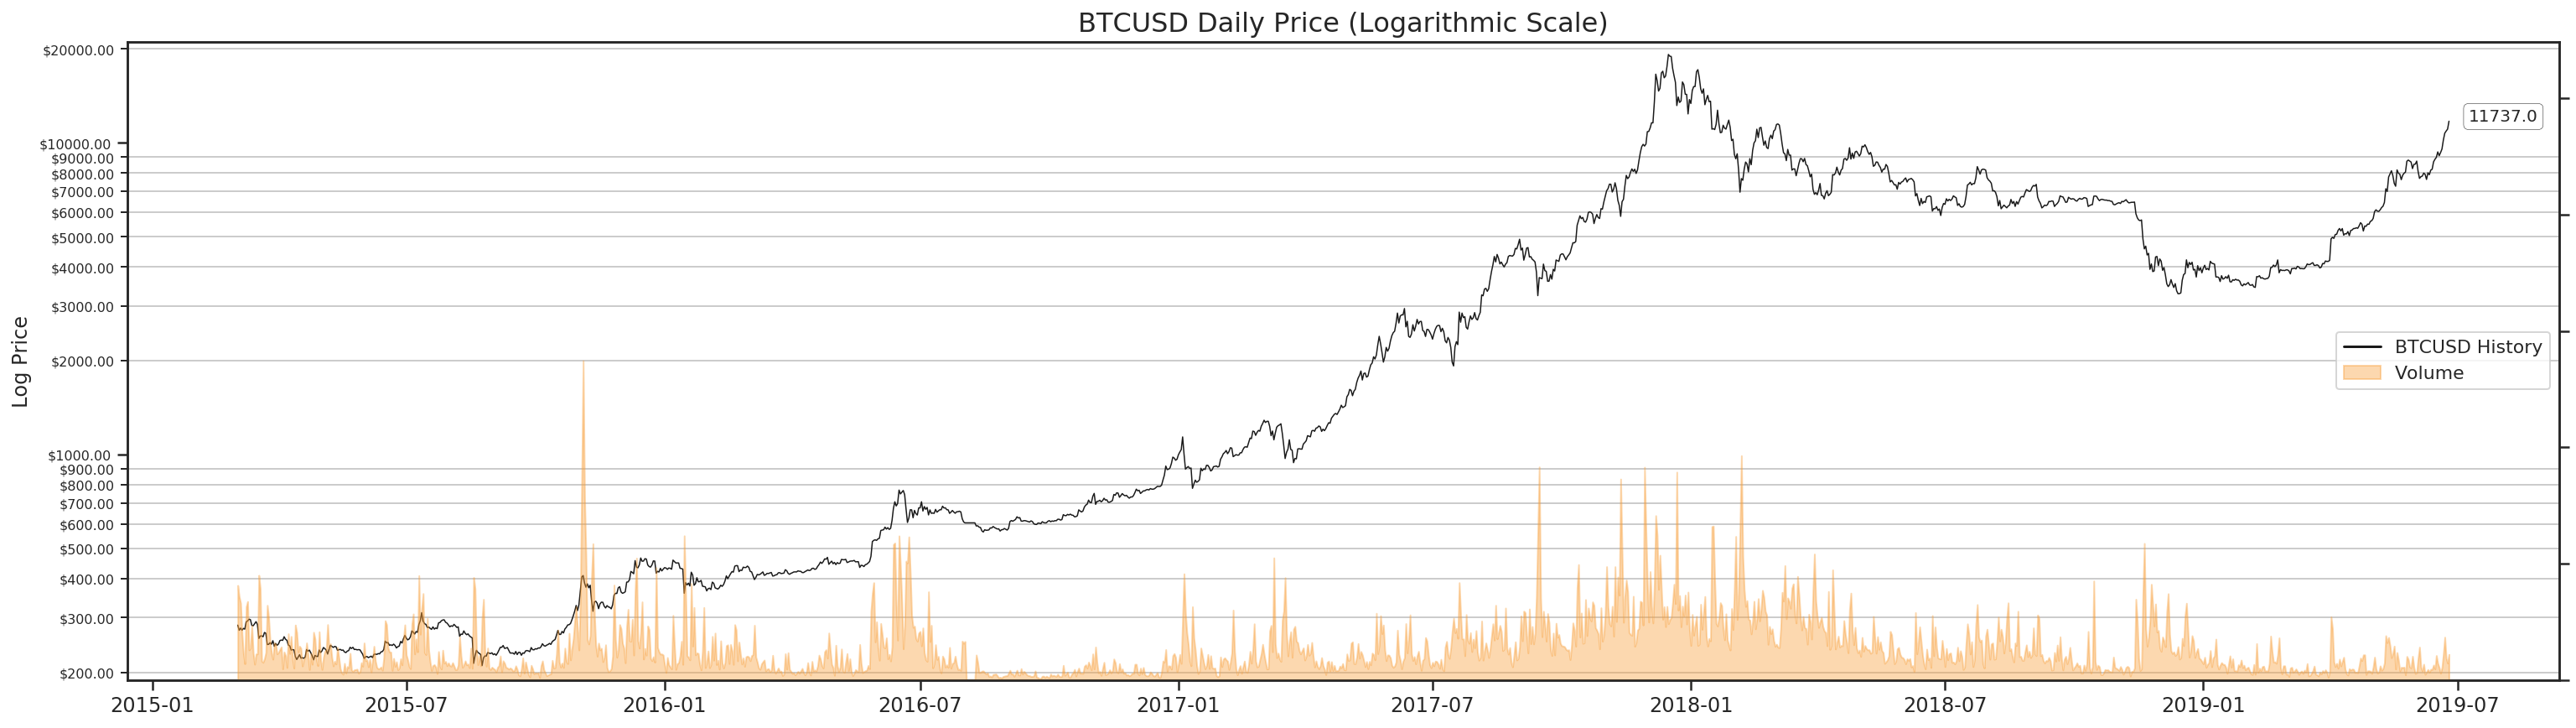

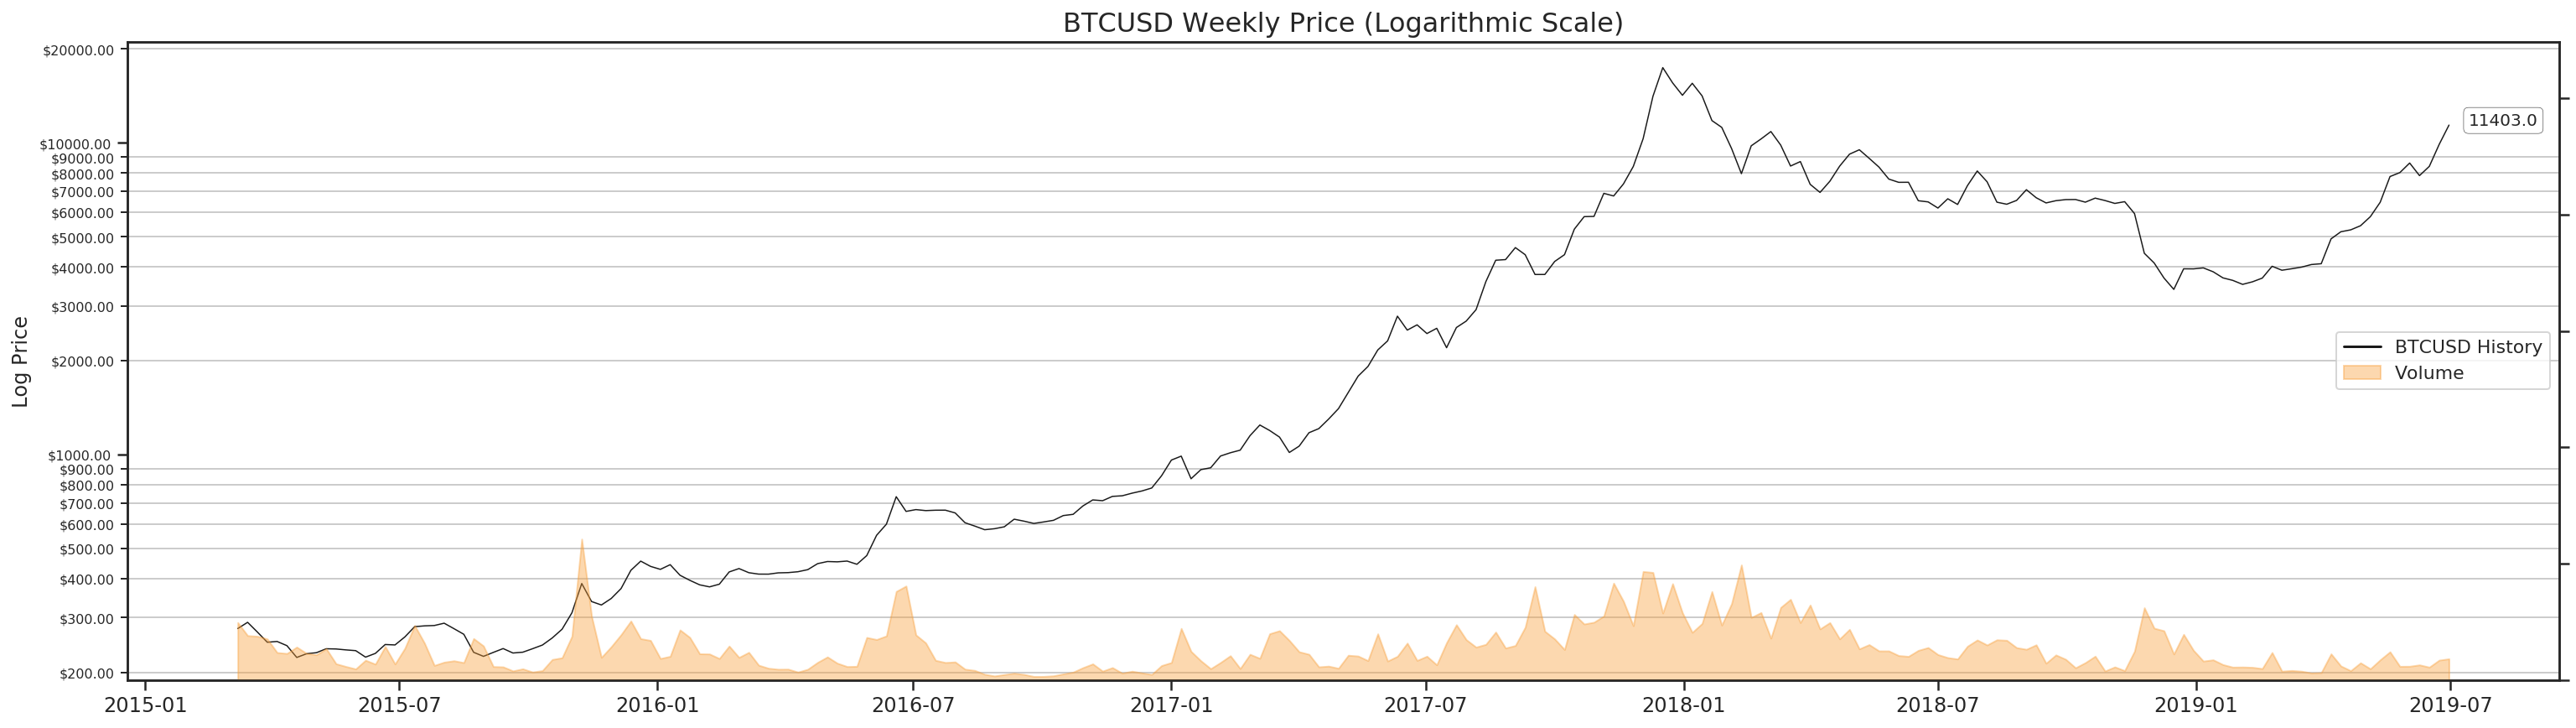

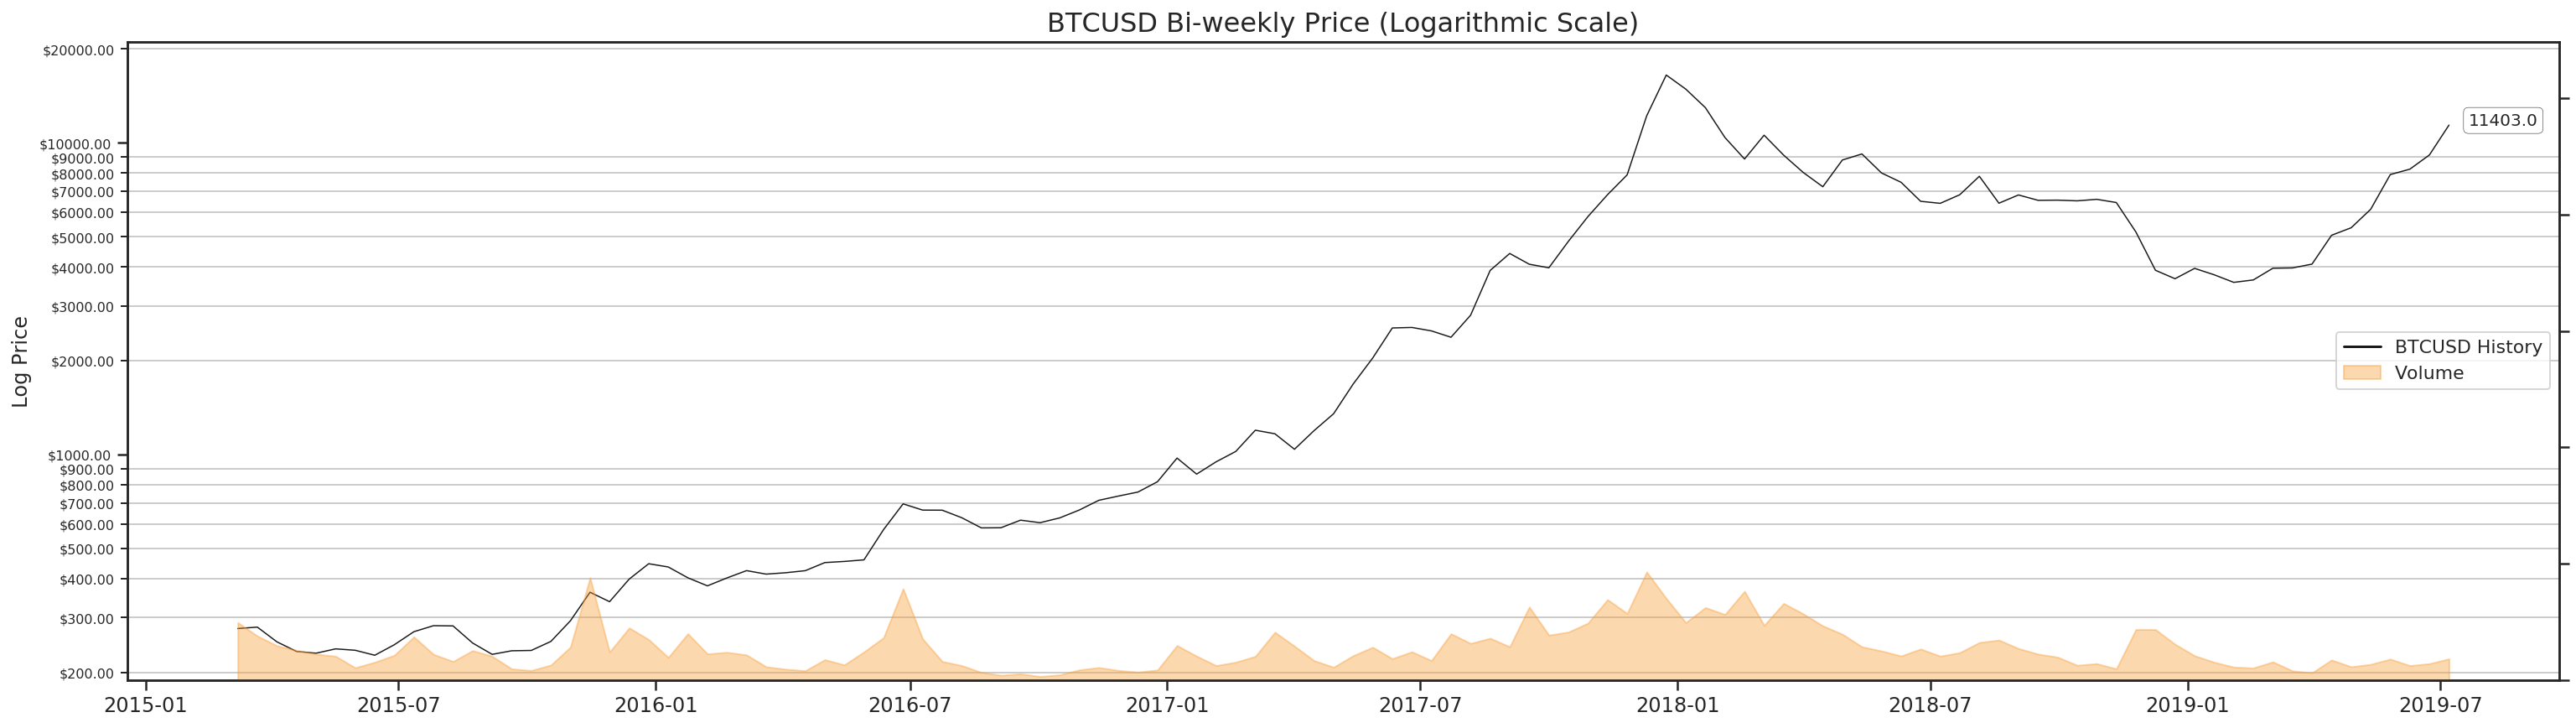

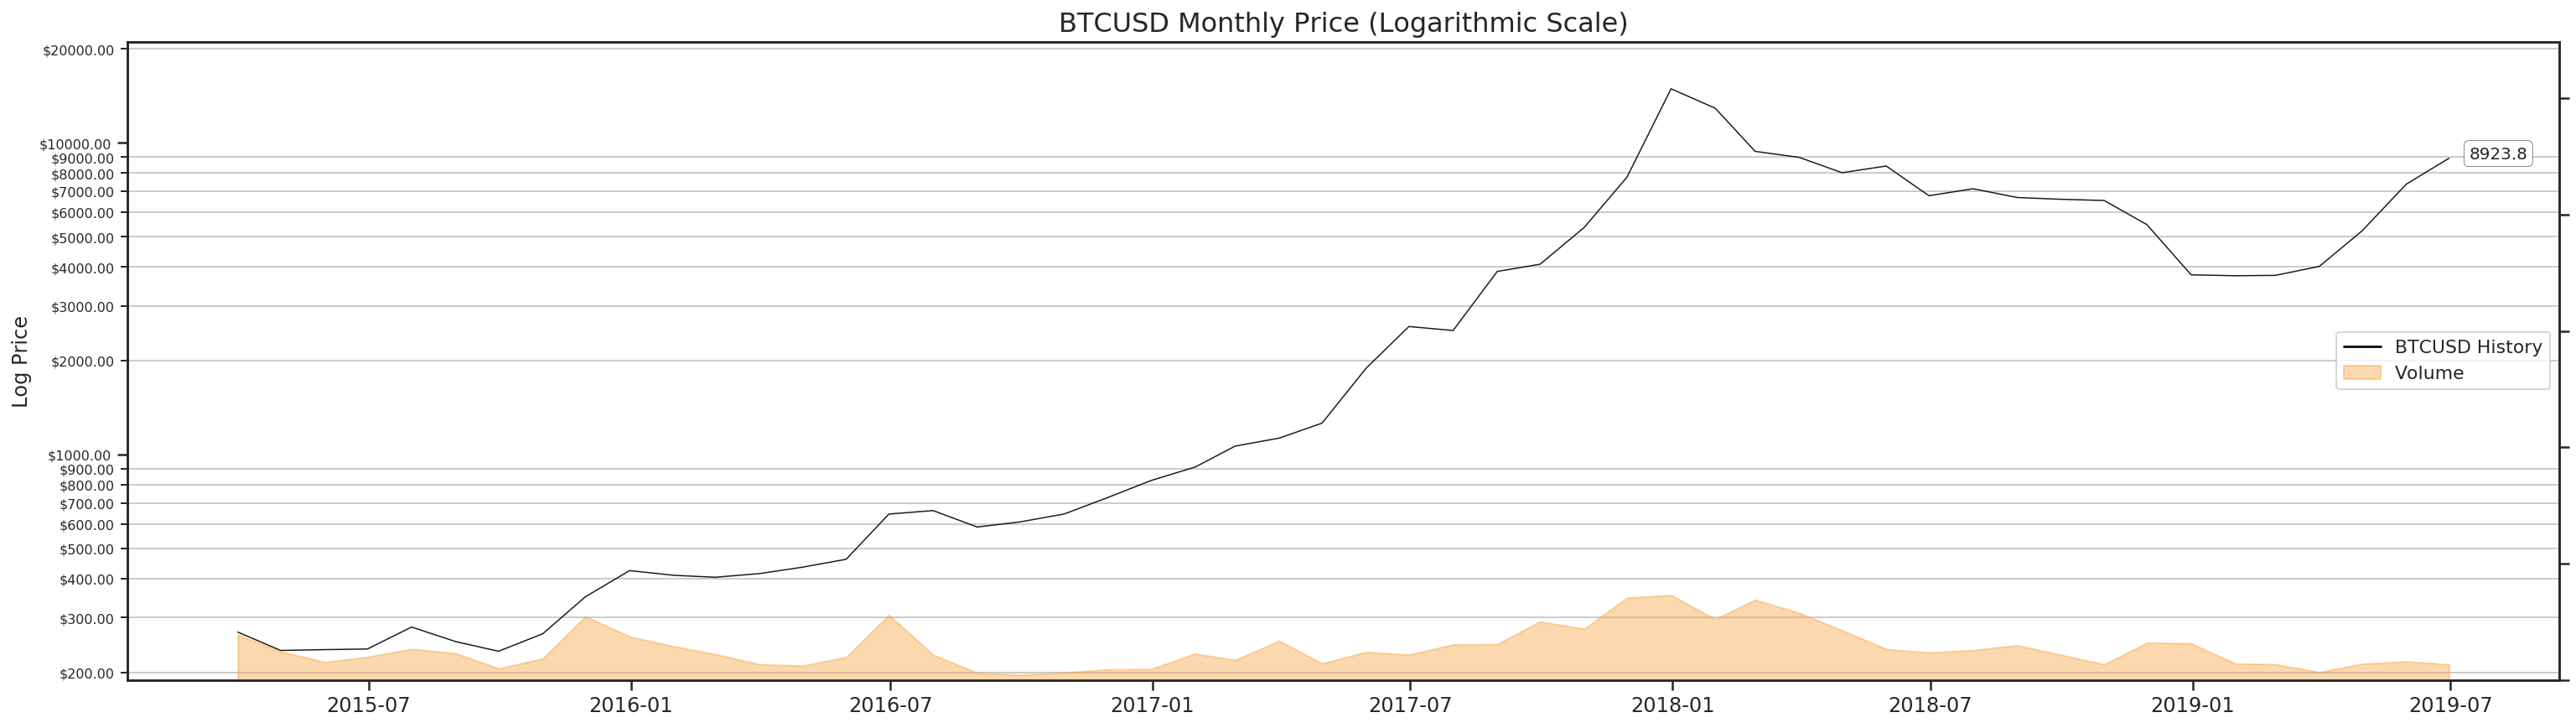

In [4]:
for df in df_list:
    make_log_price_chart(df)

## Stationarity Test
Apparently, our price data is not stationary. But before we perform any data transformation and differencing, we can create a simple stationarity test function (You might have noticed this function is a bit similar to the one mentioned in [one of my previous posts](https://0xboz.github.io/blog/how-to-run-stationarity-tests-on-cryptocurrencies-trading-data/)) for later use.
```python
def run_stationarity_test(time_series, window=10):
    """
    This window here is a bit arbitrary.
    After all, rolling average is just a visual technique to verify the stationarity.
    """
    sns.set(style="darkgrid")
    #Determing rolling statistics
    rolmean = time_series.rolling(window=window).mean()
    rolstd = time_series.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(27, 5))
    orig = plt.semilogy(time_series, color='blue',label='Original', lw=0.75, alpha=0.7)
    mean = plt.semilogy(rolmean, color='red', label='Rolling Mean', lw=1)
    std = plt.semilogy(rolstd, color='black', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    
    if 'Day' in str(time_series.index.freq):
        freq = 'Daily'
    elif 'Week: weekday=6' in str(time_series.index.freq):
        freq = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(time_series.index.freq):
        freq = 'Bi-weekly'
    elif 'MonthEnd' in str(time_series.index.freq):
        freq = 'Monthly'
    
    plt.title('{} Data Rolling Mean & Standard Deviation'.format(freq), fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()    
    
    #Perform ADF test:
    first_valid_date = time_series.first_valid_index()    
    print('Results of ADF Test:')
    dftest = adfuller(time_series.loc[first_valid_date:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
```

In [5]:
def run_stationarity_test(time_series, window=10):
    """
    This window here is a bit arbitrary.
    After all, rolling average is just a visual technique to verify the stationarity.
    """
    sns.set(style="darkgrid")
    #Determing rolling statistics
    rolmean = time_series.rolling(window=window).mean()
    rolstd = time_series.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(27, 5))
    orig = plt.semilogy(time_series, color='blue',label='Original', lw=0.75, alpha=0.7)
    mean = plt.semilogy(rolmean, color='red', label='Rolling Mean', lw=1)
    std = plt.semilogy(rolstd, color='black', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    
    if 'Day' in str(time_series.index.freq):
        freq = 'Daily'
    elif 'Week: weekday=6' in str(time_series.index.freq):
        freq = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(time_series.index.freq):
        freq = 'Bi-weekly'
    elif 'MonthEnd' in str(time_series.index.freq):
        freq = 'Monthly'
    
    plt.title('{} Data Rolling Mean & Standard Deviation'.format(freq), fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()    
    
    #Perform ADF test:
    first_valid_date = time_series.first_valid_index()    
    print('Results of ADF Test:')
    dftest = adfuller(time_series.loc[first_valid_date:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Let us run this test through our data frame list as well.
```python
for df in df_list:
    run_stationarity_test(df.price)
```

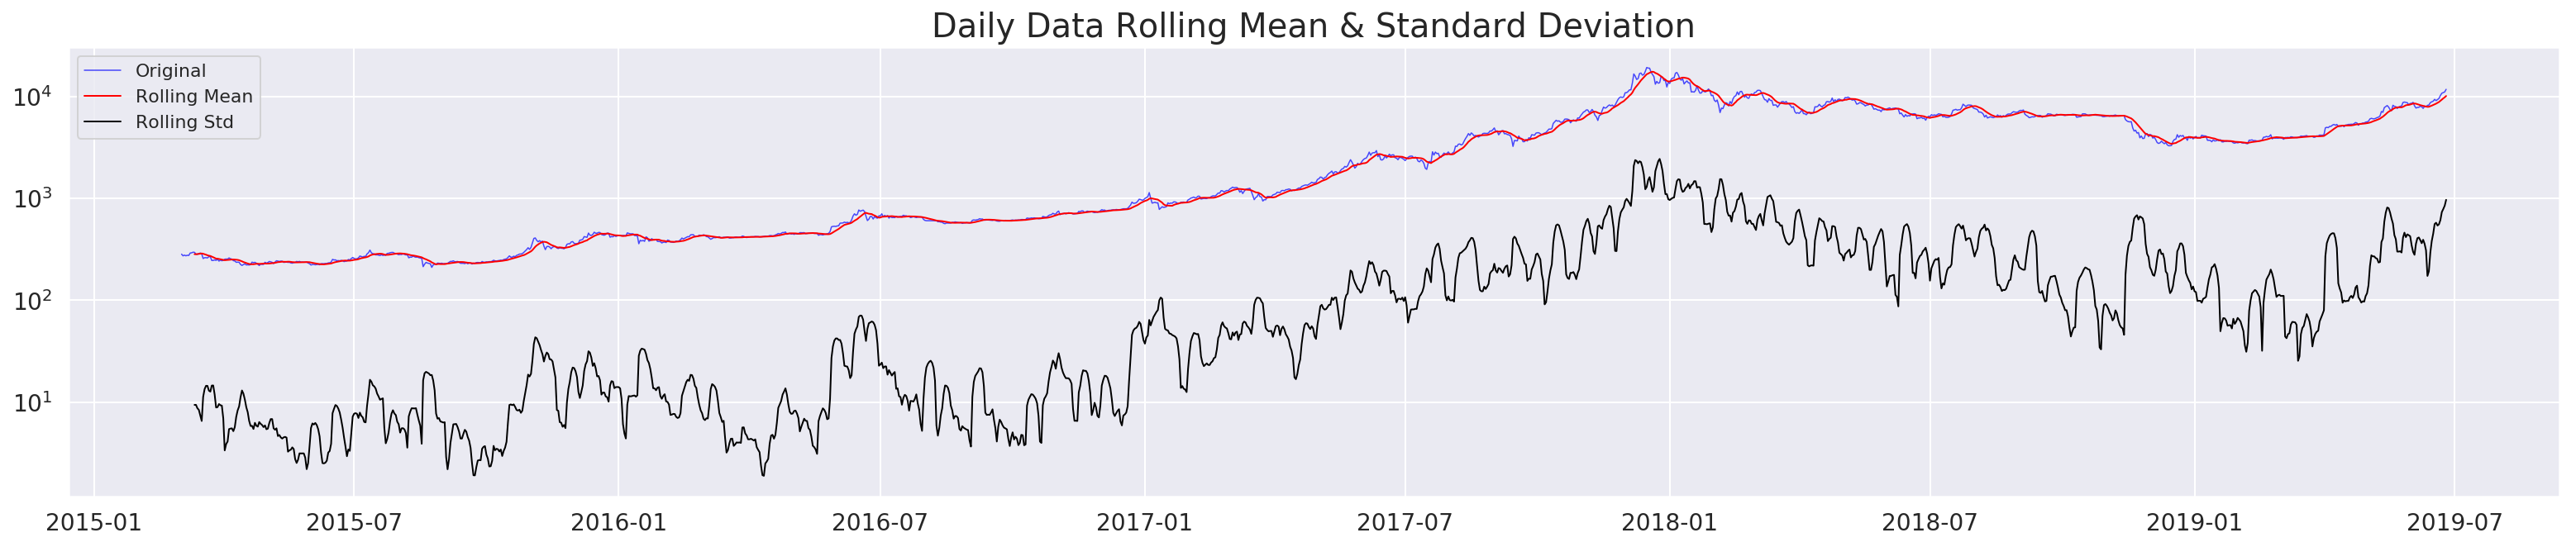

Results of ADF Test:
Test Statistic                   -1.248460
p-value                           0.652410
#Lags Used                       20.000000
Number of Observations Used    1555.000000
Critical Value (5%)              -2.863400
Critical Value (10%)             -2.567760
Critical Value (1%)              -3.434562
dtype: float64


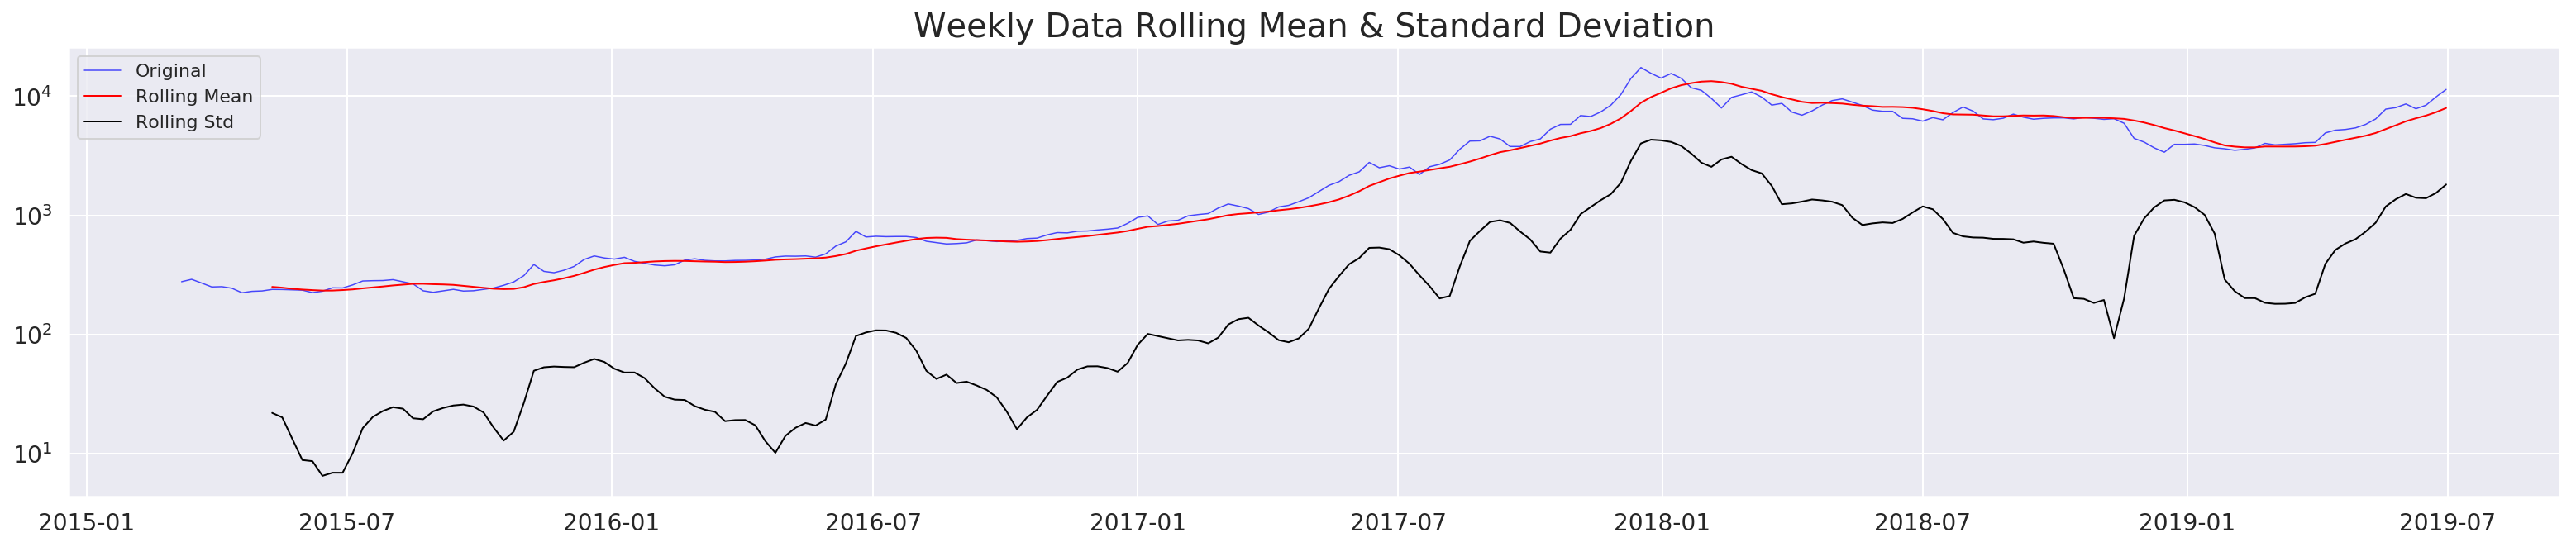

Results of ADF Test:
Test Statistic                  -0.940527
p-value                          0.774333
#Lags Used                       4.000000
Number of Observations Used    221.000000
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
Critical Value (1%)             -3.460291
dtype: float64


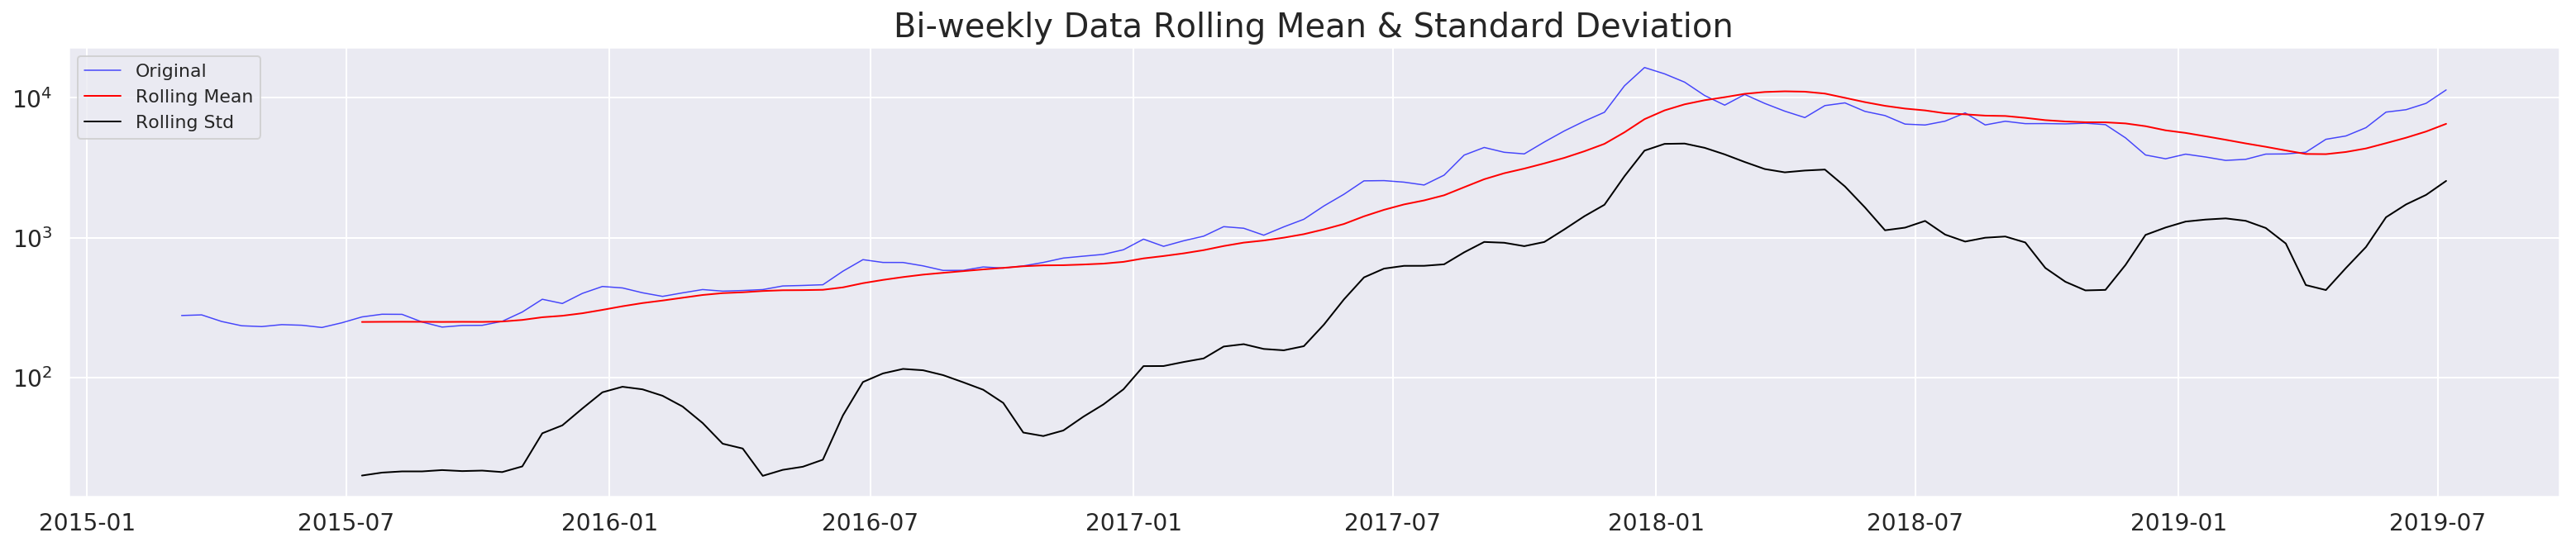

Results of ADF Test:
Test Statistic                  -0.916898
p-value                          0.782357
#Lags Used                       2.000000
Number of Observations Used    111.000000
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
Critical Value (1%)             -3.490683
dtype: float64


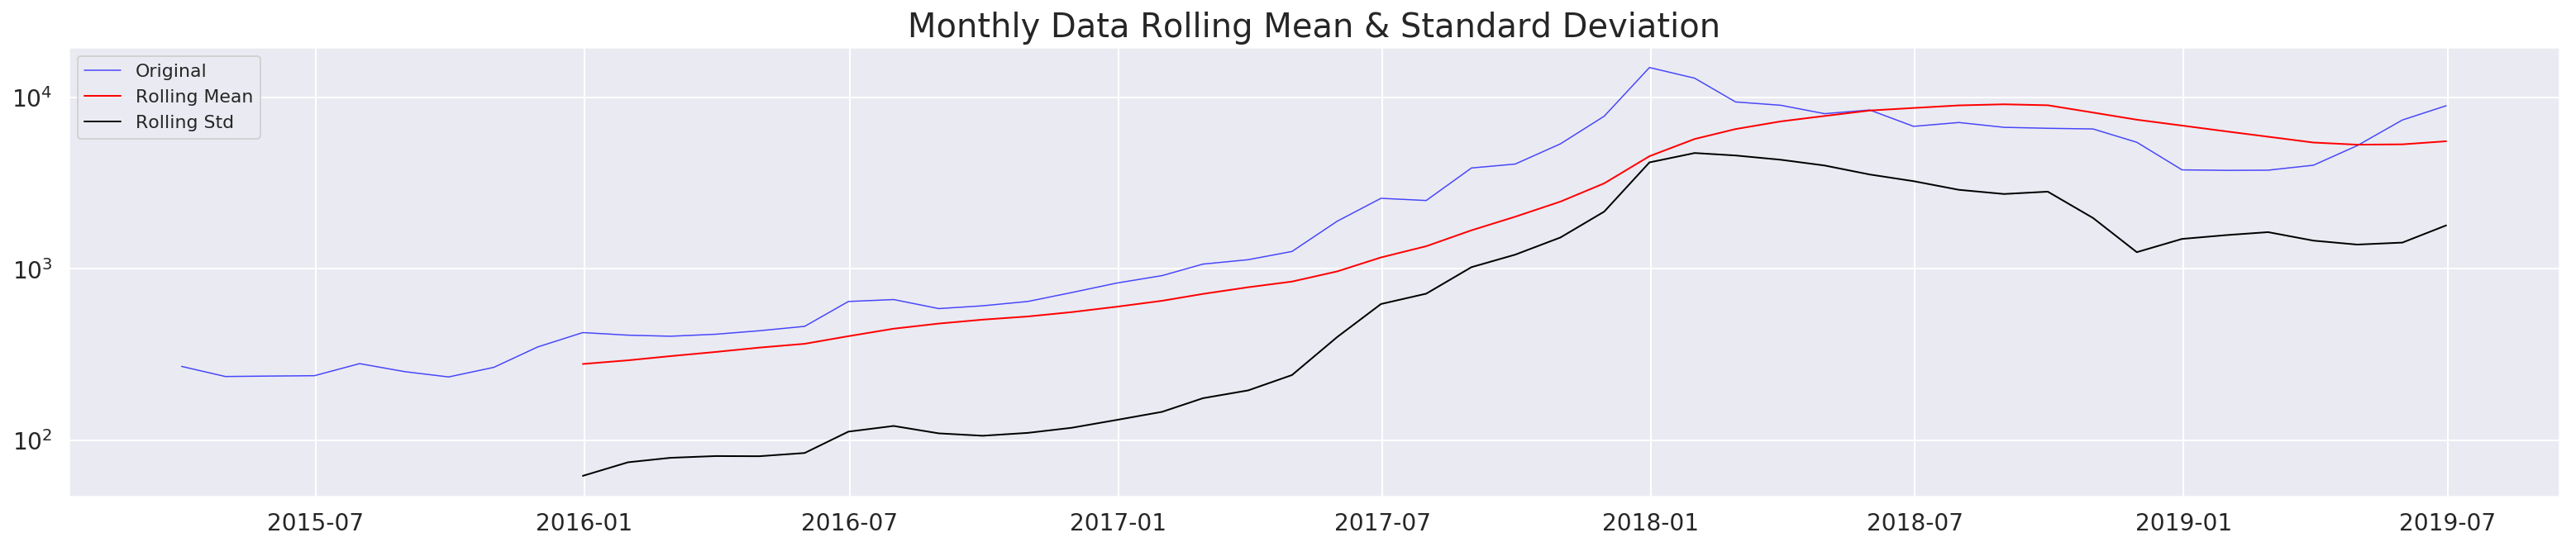

Results of ADF Test:
Test Statistic                 -1.451988
p-value                         0.557114
#Lags Used                      1.000000
Number of Observations Used    50.000000
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
Critical Value (1%)            -3.568486
dtype: float64


In [6]:
for df in df_list:
    run_stationarity_test(df.price)

Visually speaking, it is quite obvious that our price data is not stationary.

According to [Augmented Dickey-Fuller (ADF)](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) test, when ```p-value``` is greater than 0.05, we can not reject the null hypothesis that the series has a unit root. In other words, the price time series is not stationary.

Usually, we can just take the natural log of the price and be done with it, but I am going to show you another general yet powerful tool called [Box-Cox Transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation) in the upcoming series. Meanwhile, if you have any questions/comments/proposals, feel free to shoot me a message.

I have also created one [QUANT channel](https://discord.gg/JHt7UQu) in one of the most popular discords in cryptoverse. Stop by and say hi to those down-to-earth crypto folks.

Stay calm and happy trading!

# How to Create ARIMA Model Forecasting BTCUSD in Python Part 2

This post is a continuation of [part 1](https://0xboz.github.io/blog/how-to-create-arima-model-forecasting-btc-usd-in-python-part-1/). Since most of the prerequisites have been mentioned in part 1, I would recommend you to glimpse through and come back later.

The [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation) is a family of power transformations indexed by a parameter lambda. By definition, when lambda is zero, box-cox is actually using natural log to do the transformation. Since taking natural log is basically a special case for Box-Cox transformation, we are going to examine the difference on our data. Before we start, let us create a function which can help us to understand the results later.

```python
def run_box_cox(pd_dataframe):
    """
    Perform Box-Cox Transformation on column 'price'
    Save the resutls into a new column 'price_box'
    Save lmbda into a new column 'lmbda'
    """
    
    if 'Day' in str(pd_dataframe.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(pd_dataframe.index.freq):
        frequency = 'Monthly'

    sns.set(style="darkgrid")
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)   
    
    ax1 = axes[0, 0]    
    prob = stats.probplot(pd_dataframe['price'], dist=stats.norm, plot=ax1, fit=False)    
    ax1.set_title('Probability Plot Before Transformation')
        
    ax2 = axes[0, 1]
    # Perform Box-Cox Transformation
    box_cox, lmbda = stats.boxcox(pd_dataframe['price'])
    # Record new column 'price_box' in pd
    pd_dataframe['price_box'] = pd.Series(box_cox, index=pd_dataframe.index)
    # Record lmbda in pd
    pd_dataframe['lmbda'] = lmbda
    prob = stats.probplot(box_cox, dist=stats.norm, plot=ax2, fit=False)
    ax2.set_title('Probability Plot After Transformation')    
    
    ax3 = axes[1, 0]
    sns.kdeplot(pd_dataframe['price'], shade=True, ax=ax3, label='KDE Price')
    ax3.set_title('KDE Plot Before Transformation')
    
    ax4 = axes[1, 1]
    sns.kdeplot(box_cox, shade=True, ax=ax4, label='KDE Price Box', color='r')
    ax4.set_title('KDE Plot After Transformation')
    
    f.suptitle('BTCUSD {} Price Box-Cox Transformation'.format(frequency), fontsize=16)
    f.subplots_adjust(top=0.91, hspace=0.3)

    plt.show()
```

In [21]:
# Box-Cox Transformation Function
def run_box_cox(pd_dataframe):
    """
    Perform Box-Cox Transformation on column 'price'
    Save the resutls into a new column 'price_box'
    Save lmbda into a new column 'lmbda'
    """
    
    if 'Day' in str(pd_dataframe.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(pd_dataframe.index.freq):
        frequency = 'Monthly'

    sns.set(style="darkgrid")
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)   
    
    ax1 = axes[0, 0]    
    prob = stats.probplot(pd_dataframe['price'], dist=stats.norm, plot=ax1, fit=False)    
    ax1.set_title('Probability Plot Before Transformation')
        
    ax2 = axes[0, 1]
    # Perform Box-Cox Transformation
    box_cox, lmbda = stats.boxcox(pd_dataframe['price'])
    # Record new column 'price_box' in pd
    pd_dataframe['price_box'] = pd.Series(box_cox, index=pd_dataframe.index)
    # Record lmbda in pd
    print(lmbda)
    pd_dataframe['lmbda'] = lmbda
    prob = stats.probplot(box_cox, dist=stats.norm, plot=ax2, fit=False)
    ax2.set_title('Probability Plot After Transformation')    
    
    ax3 = axes[1, 0]
    sns.kdeplot(pd_dataframe['price'], shade=True, ax=ax3, label='KDE Price')
    ax3.set_title('KDE Plot Before Transformation')
    
    ax4 = axes[1, 1]
    sns.kdeplot(box_cox, shade=True, ax=ax4, label='KDE Price Box', color='r')
    ax4.set_title('KDE Plot After Transformation')
    
    f.suptitle('BTCUSD {} Price Box-Cox Transformation'.format(frequency), fontsize=16)
    f.subplots_adjust(top=0.91, hspace=0.3)

    plt.show()

While we are at it, let us also create an inverse function for Box-Cox transformation.
```python
def inverse_box_cox(time_series, lmbda):
    """
    Inverse Box-Cox Transformation
    """
    if lmbda == 0:
      return(np.exp(time_series))
    else:
      return(np.exp(np.log(lmbda*time_series+1)/lmbda))
```

In [22]:
# Inverse Box-Cox Transformation Function
def inverse_box_cox(time_series, lmbda):
    """
    Inverse Box-Cox Transformation
    """
    if lmbda == 0:
      return(np.exp(time_series))
    else:
      return(np.exp(np.log(lmbda*time_series+1)/lmbda))

Run it through our data sets and see what happens.
```python
for df in df_list:
    run_box_cox(df)
```

<div class="notice--info">
    <p>A <a href="https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm">probability plot</a> (a sample vs a theoretical distribution) is not a <a href="https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm">QQ-plot</a>. A QQ-plot compares two samples. Although many resources are contradicting with NIST definition, plotting a sample is essentially the same as using the empirical distribution function.</p>
    <p>nevertheless, we are plotting one dsitribution's quantiles against another.</p>
    <p>A more thorough discussion can be found on <a href="https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy">stackoverflow</a>.</p>
</div>

0.0076641137382780986


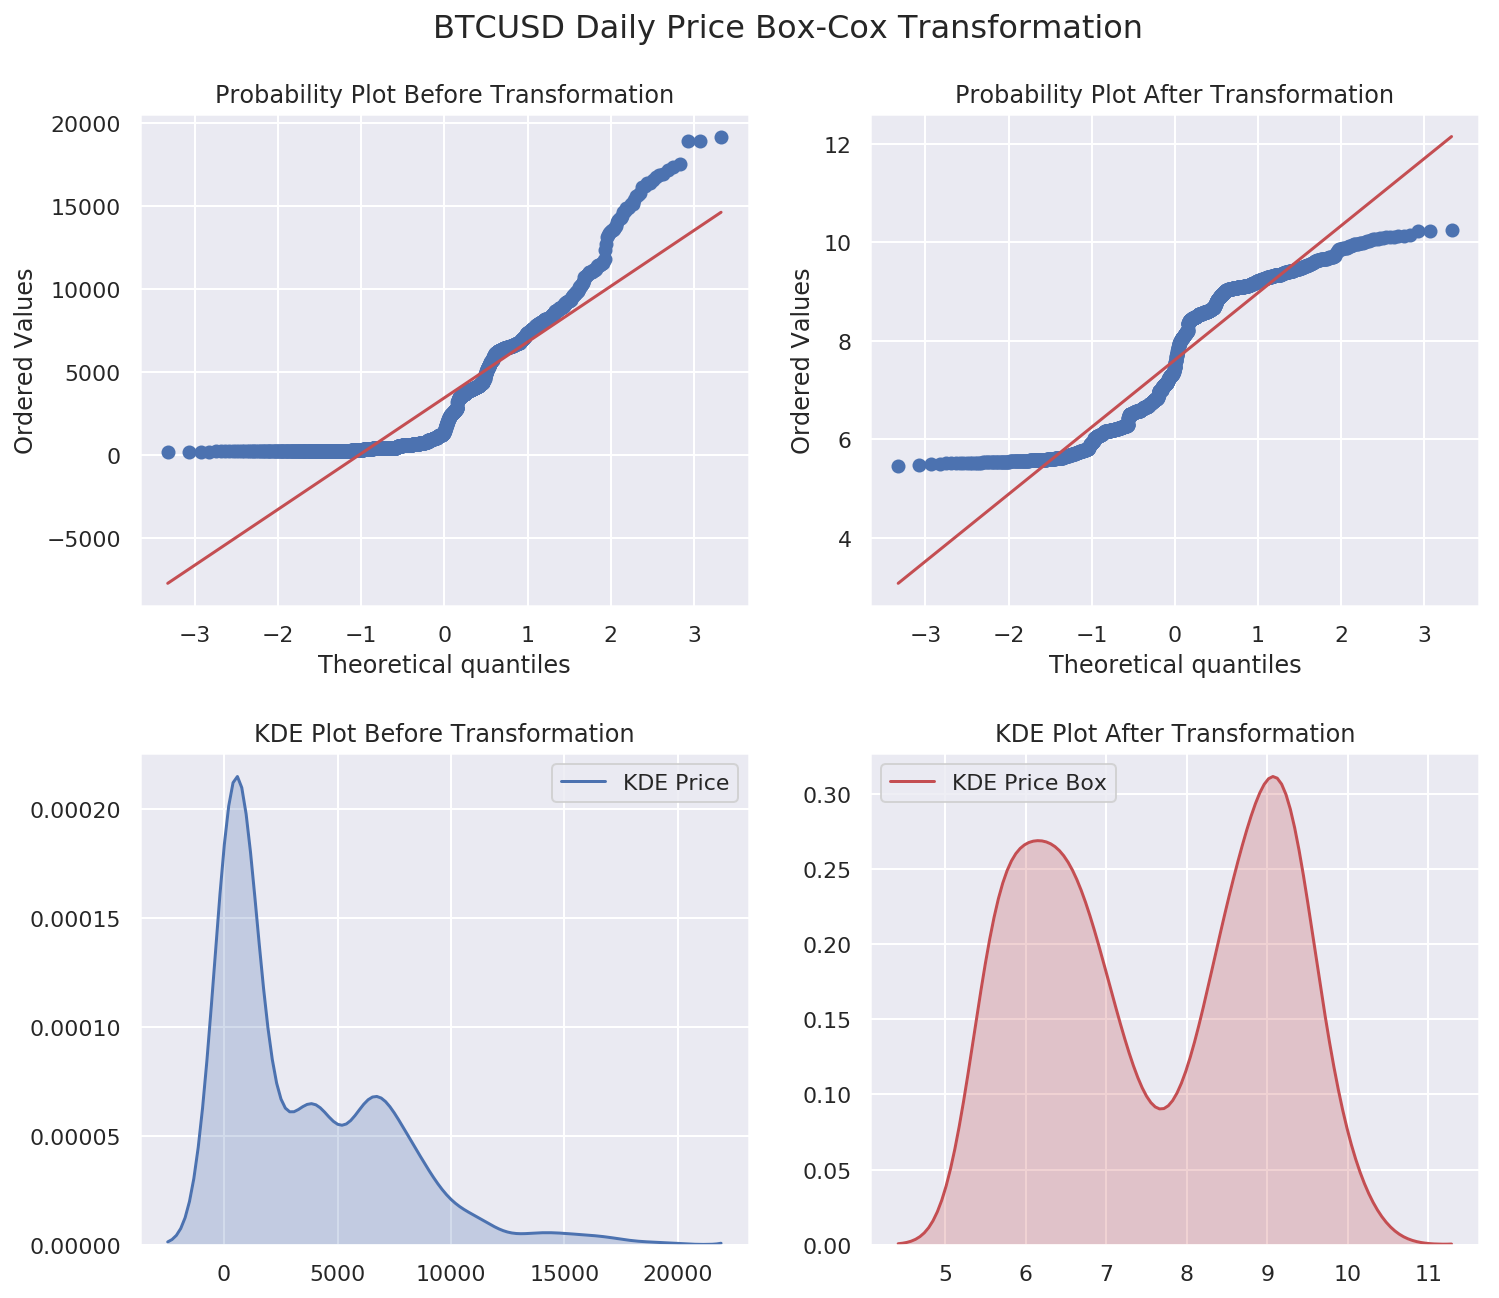

0.01021778640361785


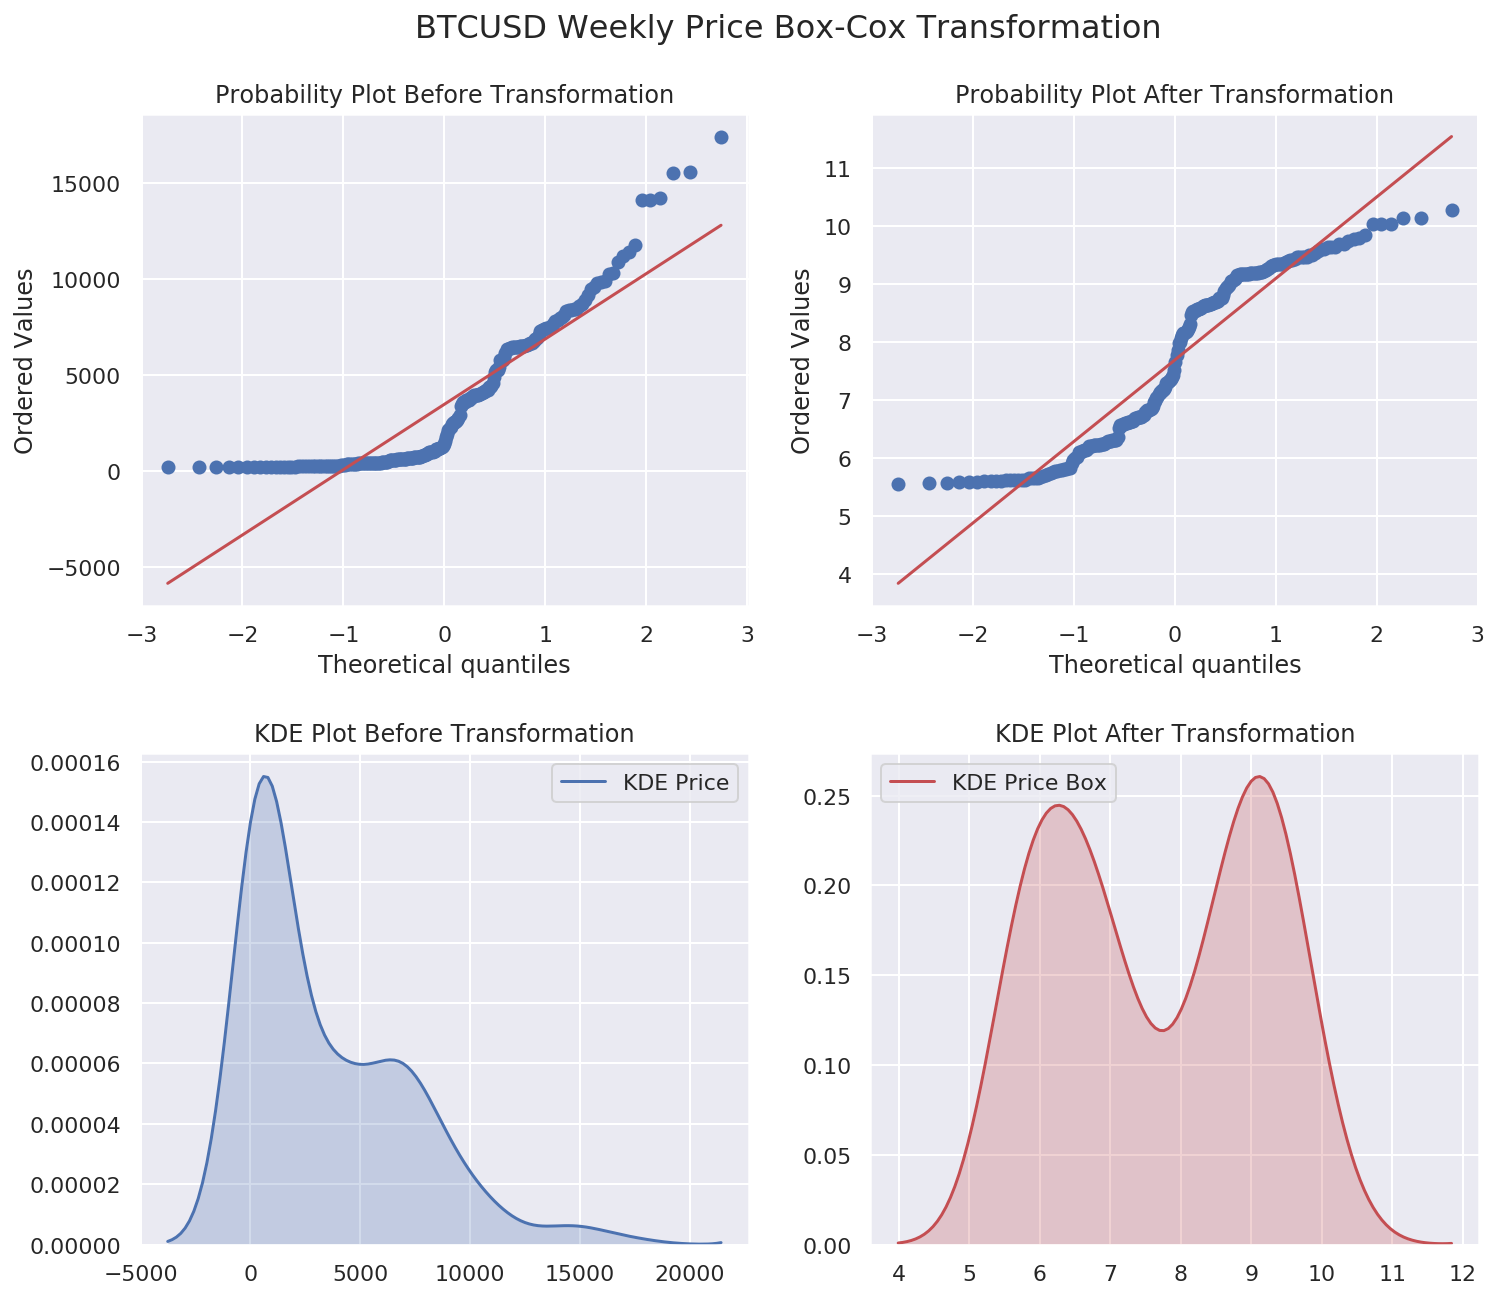

0.010175903626155641


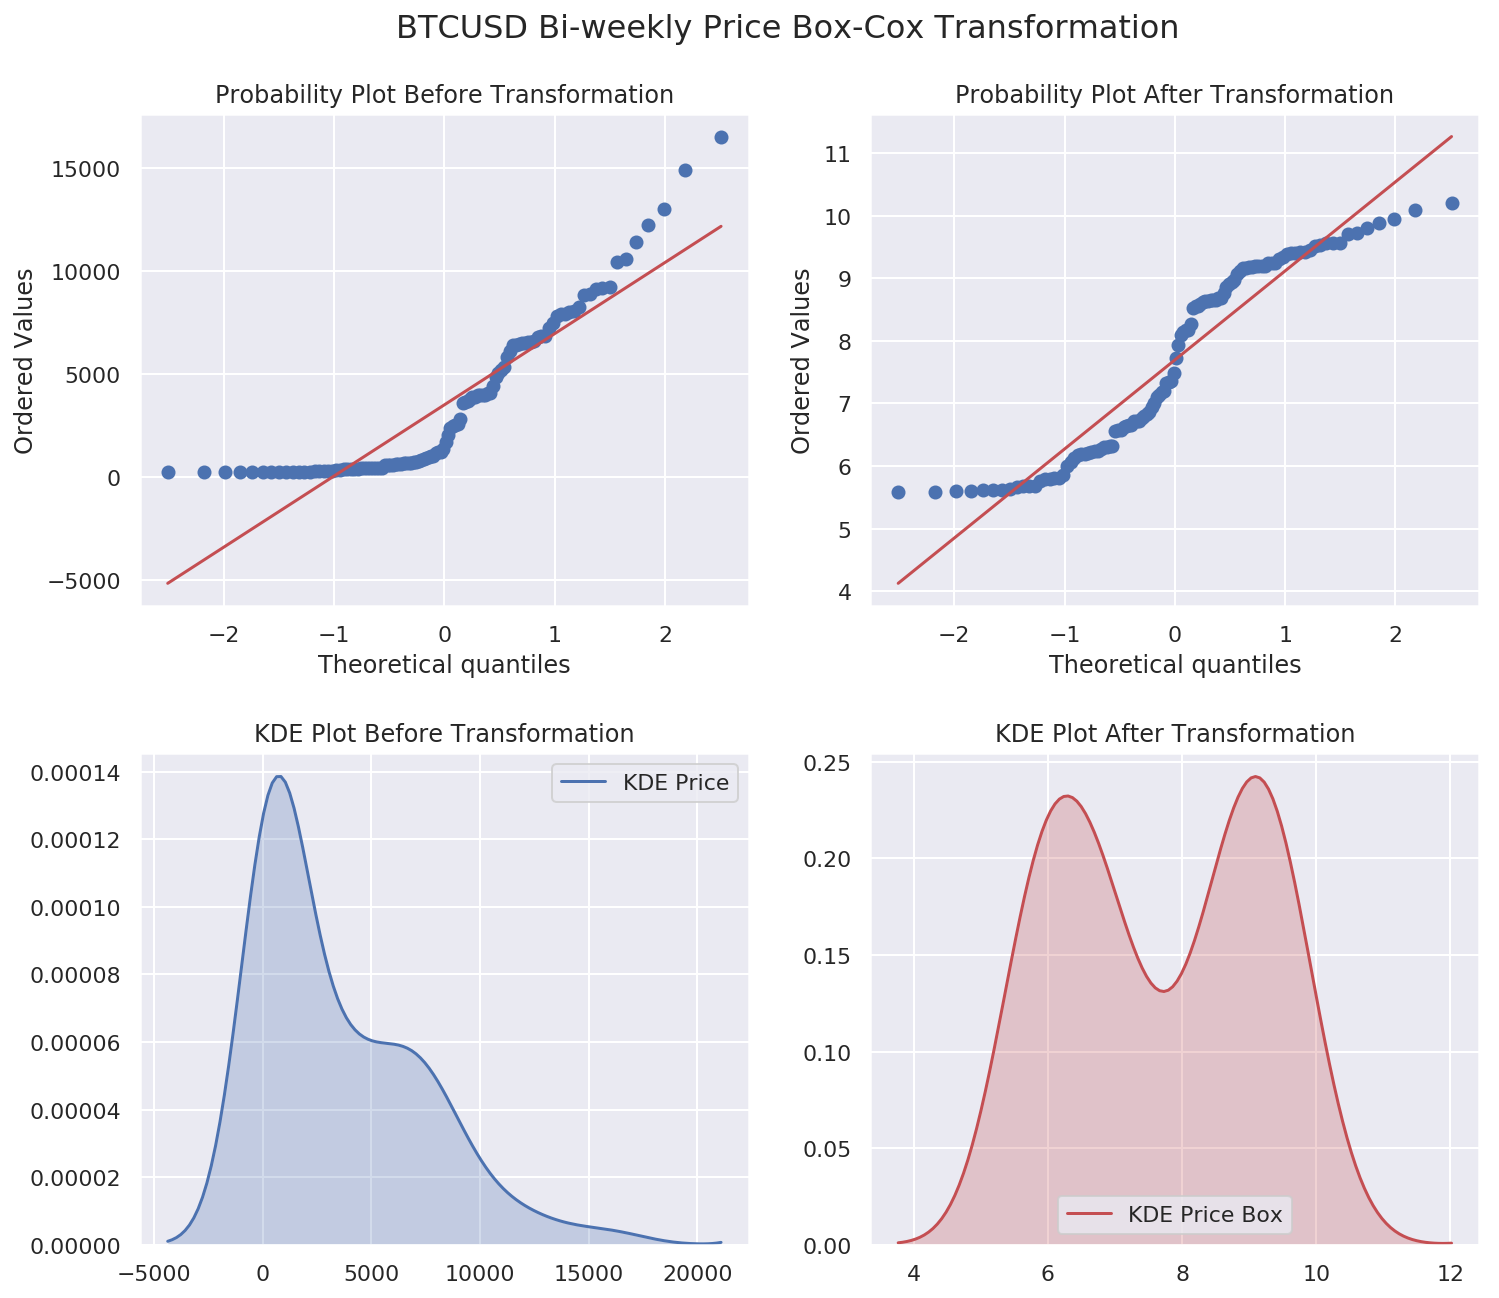

0.015800283029988472


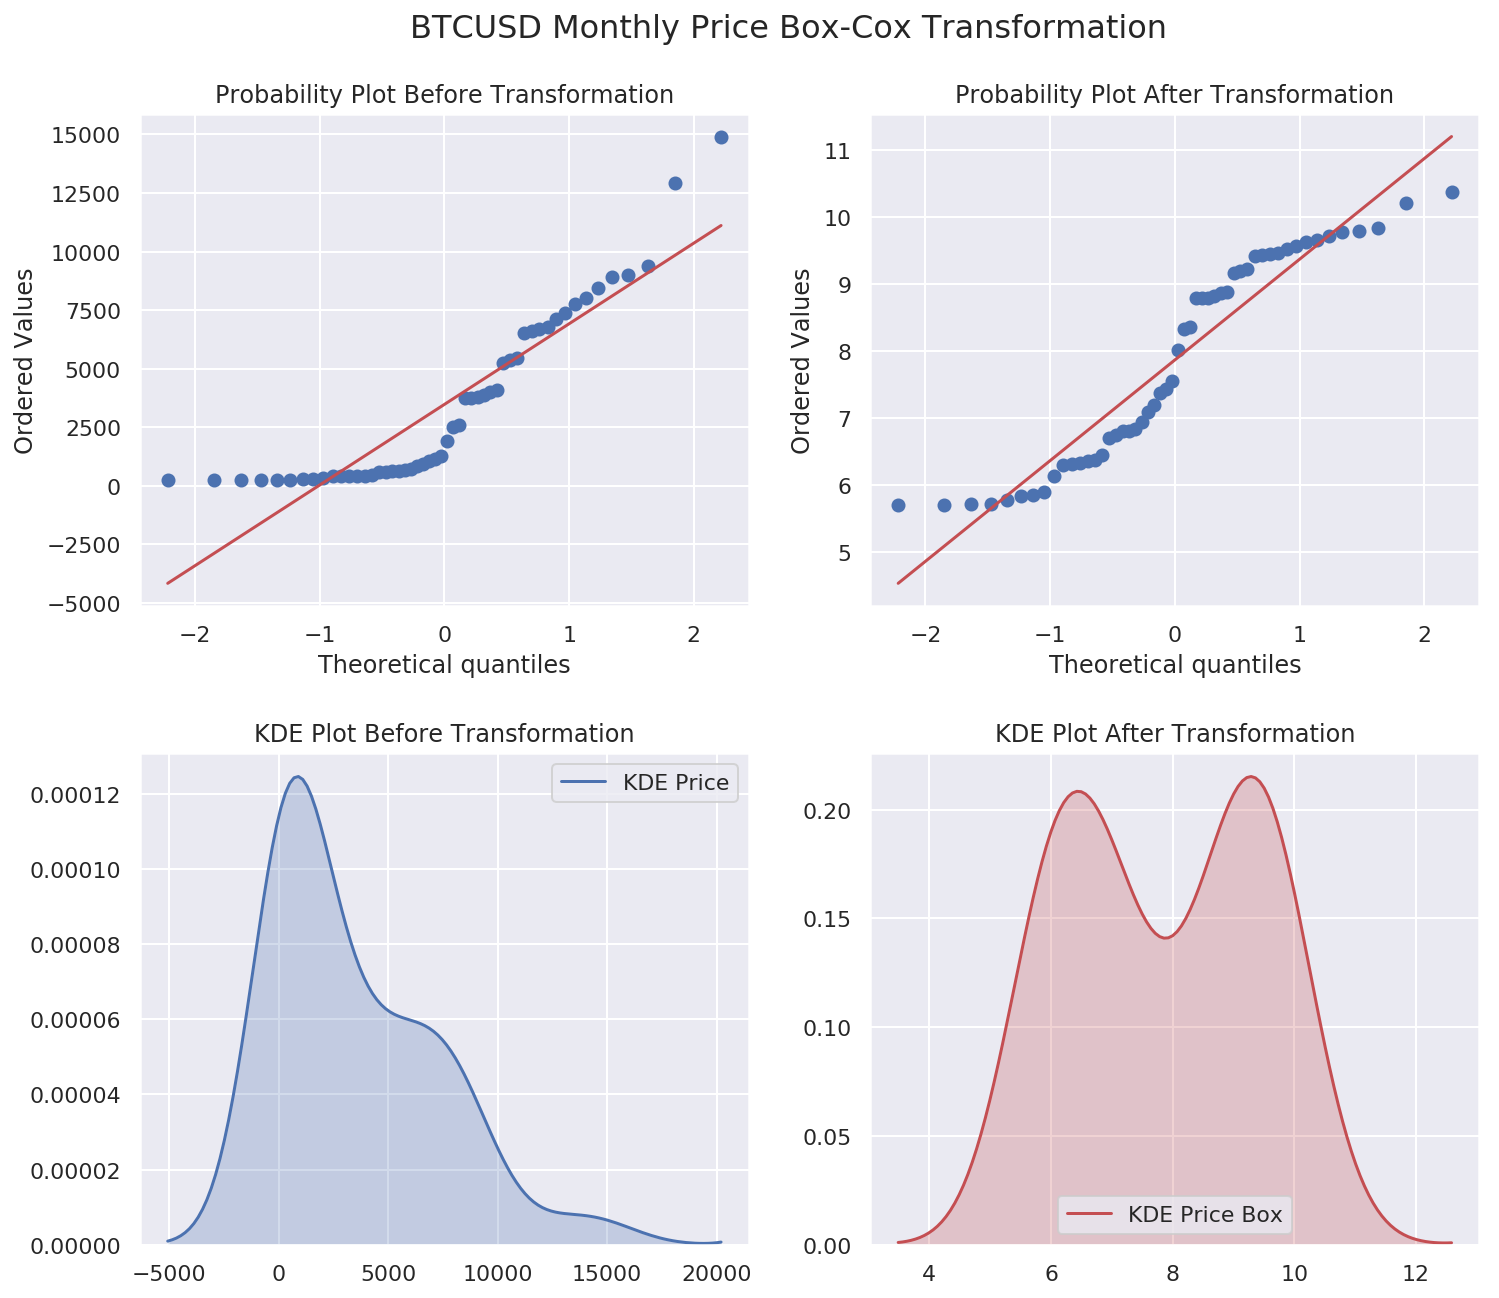

In [23]:
for df in df_list:
    run_box_cox(df)

After applying Box-Cox with a particular value of lambda, the process may look stationary. However, it is often to see the series does not appear to be stationary even if after applying the Box-Cox transformation. From the results above, we have four different ```lmbda``` values of 0.00766, 0.0102, 0.0101 and 0.0158 for daily, weekly, bi-weekly and monthly data sets, respectively. Not that quite close to zero, isn't it?

Unfortunately, our data is still far away from be stationary after Box-Cox transformation. The next step is differencing. For the sake of this series, we are not going to dive into seasonality. Instead, we will apply the first-order differencing. I am sure it will be quite fascinating to investigate the seasonality of our data, but that will be left for another future post. 

```python
# Take the first-order difference for our data sets
print('Box-Cox Transformed Price First-order Differencing ADF Test')
for df in df_list:
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    df['price_box_diff_1'] = df['price_box'] - df['price_box'].shift(1)
    print('{} : p={}'.format(frequency, adfuller(df.price_box_diff_1[1:])[1]))
```

In [99]:
# Take the first-order difference for our data sets
print('Box-Cox Transformed Price First-order Differencing ADF Test')
for df in df_list:
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    df['price_box_diff_1'] = df['price_box'] - df['price_box'].shift(1)
    print('{} : p={}'.format(frequency, adfuller(df.price_box_diff_1[1:])[1]))

Box-Cox Transformed Price First-order Differencing ADF Test
Daily : p=1.4350549191553701e-27
Weekly : p=1.9953078780986301e-19
Bi-weekly : p=1.4329230115109643e-09
Monthly : p=3.834668265736053e-05


Looks good! Now it is time to investigate autocorrelations (ADF) and partial autocorrelations (PADF). Honestly, I have been struggling to understand those two. Thanks to [ritvikmath's video](https://www.youtube.com/watch?v=DeORzP0go5I), I have a much clearer picture of what I am getting myself into. Anyways, let us create a function called ```run_acf_pacf```.

```python
def run_acf_pacf(time_series, title, lags=40):

    sns.set(style='darkgrid')
    fig_acf_pacf = plt.figure(figsize=(21,7))
    
    # Start time series from the first valid entry
    first_valid_date = time_series.first_valid_index()
    time_series = time_series.loc[first_valid_date:]

    # ACF Chart
    ax_acf = plt.subplot2grid((5, 10), (0, 0), rowspan=3, colspan=5)
    plot_acf(time_series, lags=lags, ax=ax_acf, lw=1)
    plt.title('', fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation=0)
    plt.title('Estimated Autocorreclations (ACF)', fontsize=14)

    # PACF Chart
    ax_pacf = plt.subplot2grid((5, 10), (0, 5), rowspan=3, colspan=5)
    plot_pacf(time_series, lags=lags, ax=ax_pacf, lw=1)
    plt.title('', fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation=0)
    plt.title('Estimated Partial Autocorreclations (PACF)', fontsize=14)

    plt.subplots_adjust(left=0.1, bottom=0.15, right=1, top=0.90, wspace=0.7, hspace=0)
    plt.suptitle(title, fontsize=20)
    plt.show()
```

In [105]:
def run_acf_pacf(time_series, lags=40):

    sns.set(style='darkgrid')
    fig_acf_pacf = plt.figure(figsize=(21,7))
    
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    
    # Start time series from the first valid entry
    first_valid_date = time_series.first_valid_index()
    time_series = time_series.loc[first_valid_date:]

    # ACF Chart
    ax_acf = plt.subplot2grid((5, 10), (0, 0), rowspan=3, colspan=5)
    plot_acf(time_series, lags=lags, ax=ax_acf, lw=1)
    plt.title('', fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation=0)
    plt.title('Estimated Autocorreclations (ACF)', fontsize=14)

    # PACF Chart
    ax_pacf = plt.subplot2grid((5, 10), (0, 5), rowspan=3, colspan=5)
    plot_pacf(time_series, lags=lags, ax=ax_pacf, lw=1)
    plt.title('', fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation=0)
    plt.title('Estimated Partial Autocorreclations (PACF)', fontsize=14)

    plt.subplots_adjust(left=0.1, bottom=0.15, right=1, top=0.90, wspace=0.7, hspace=0)
    title = 'BTCUSD {} First-order Differencing'.format(frequency)
    plt.suptitle(title, fontsize=20)
    plt.show()

Similarly, we run ACF and PACF through those four data sets.
```python
for df in df_list:
    run_acf_pacf(df['price_box_diff_1'], lags=40)
```

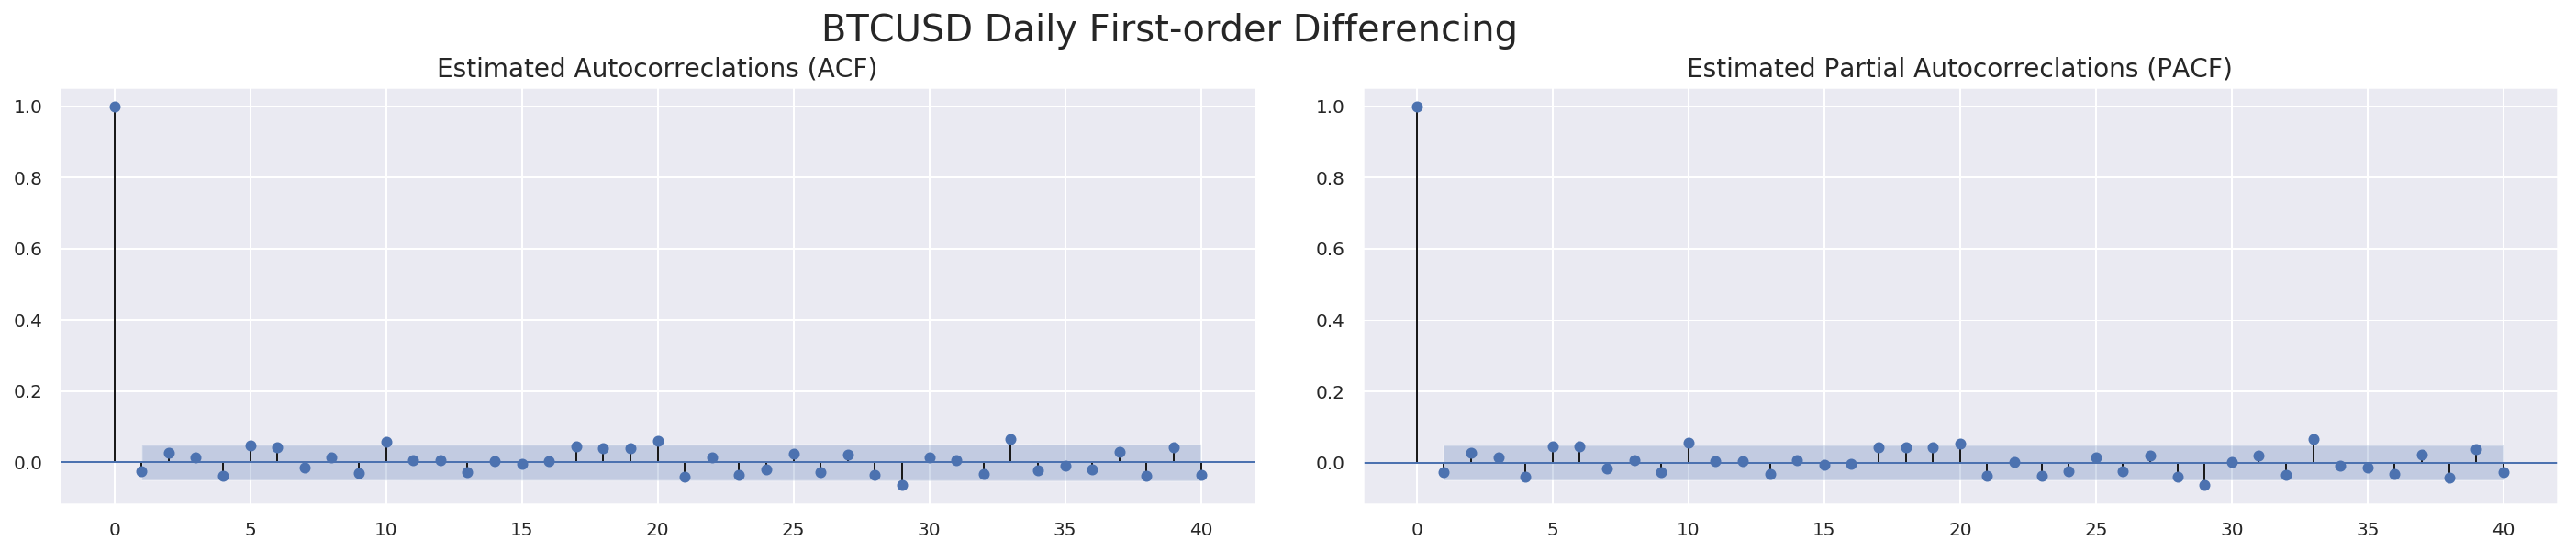

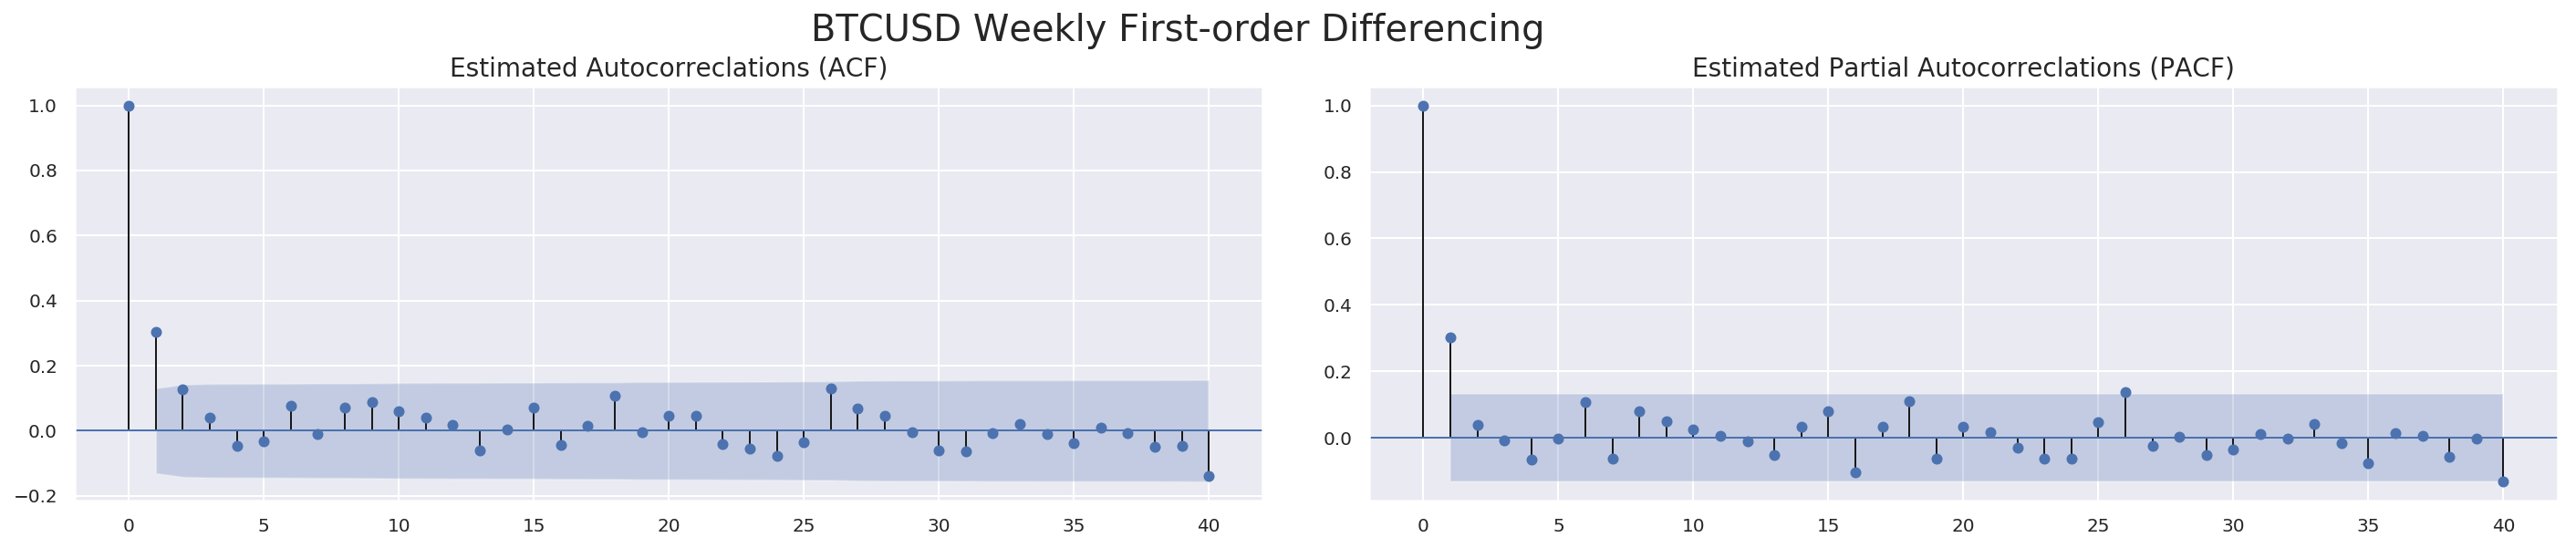

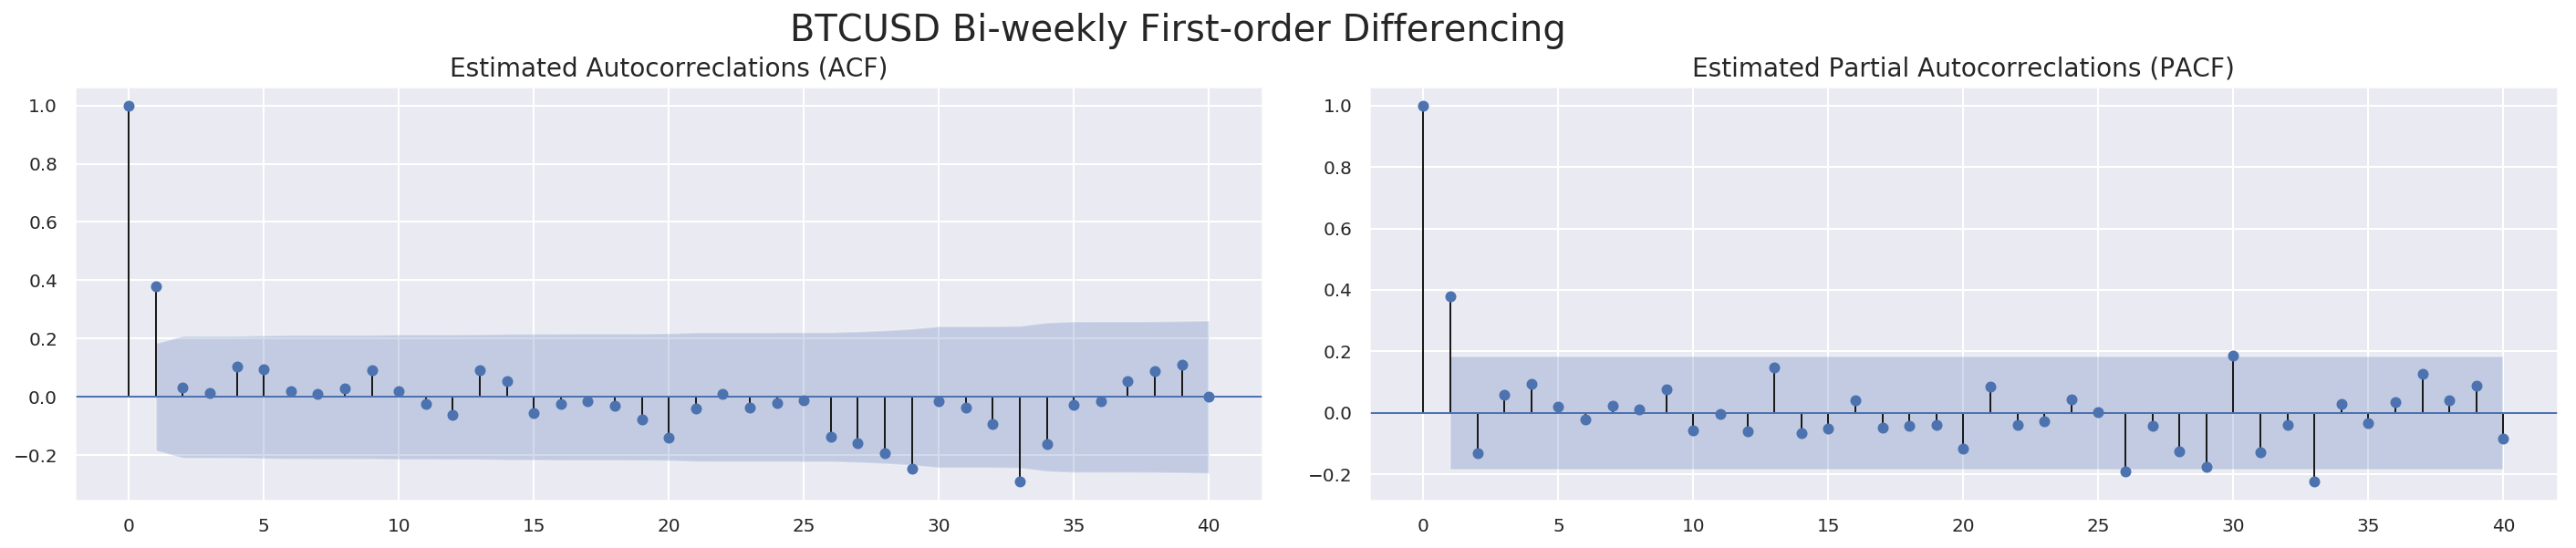

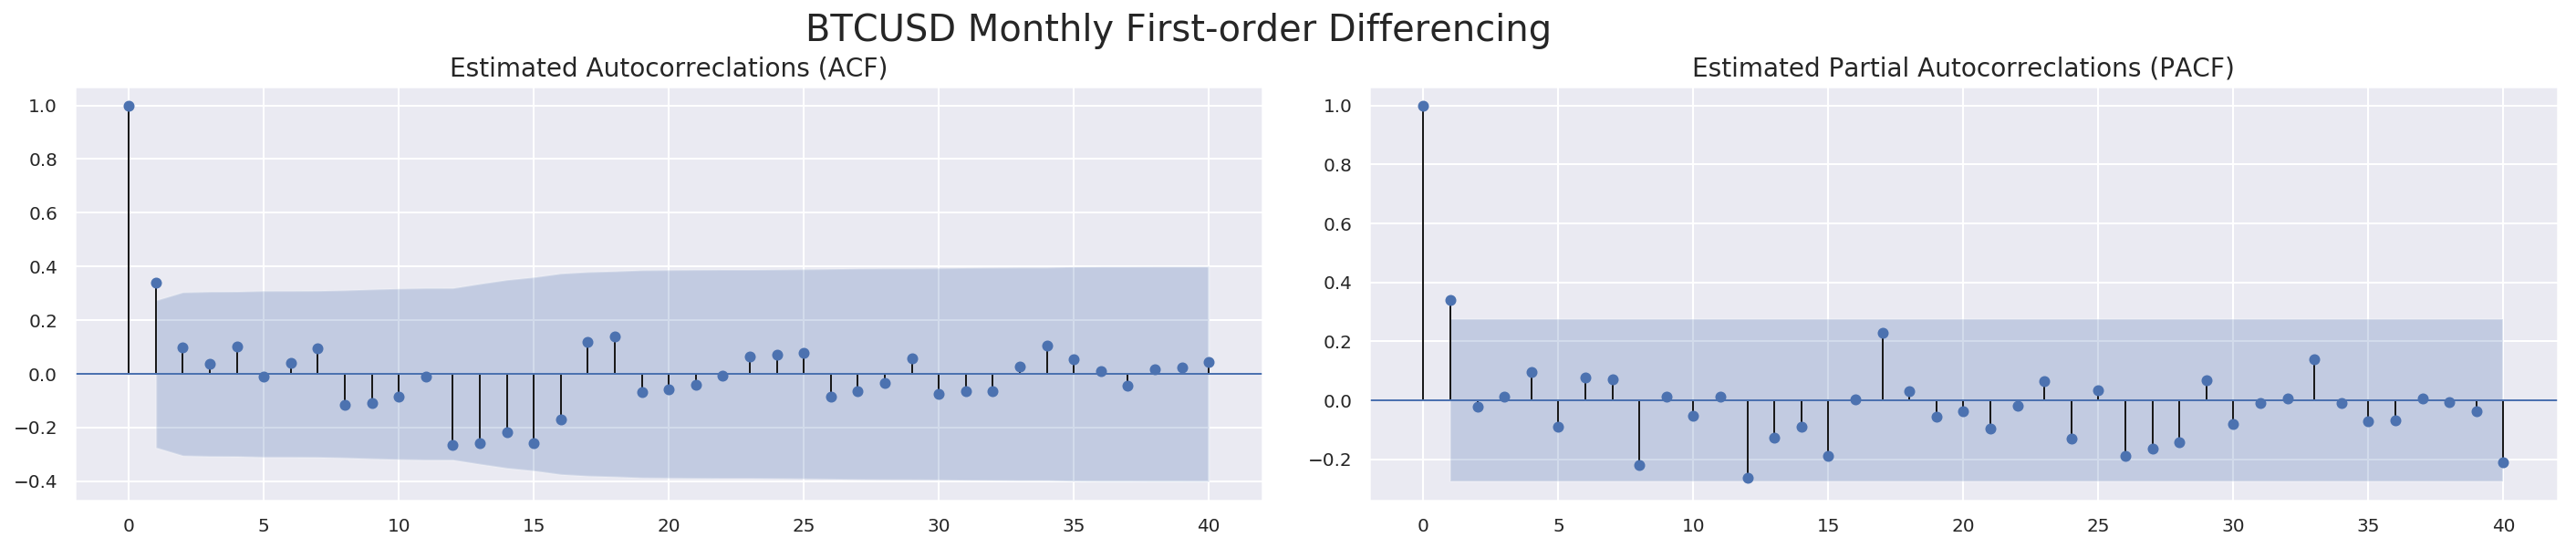

In [106]:
for df in df_list:
    run_acf_pacf(df['price_box_diff_1'], lags=40)

So far we know we are going to stick with ```d=1```. What about ```p``` and ```q```? For ```q```, all four data sets seem to have a value less than 3 based on estimated autocorrelations. As to ```p```, we might be able to get away with a value less than 10 according to PACF results. We are going to utilize model selectors to pick the best one from a range of  ```(p, d, q)``` combinations. Here is how each model selector works. The selector measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest value. The model selectors include [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion), [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and [Hannan–Quinn Information Criterion (HQIC)](https://en.wikipedia.org/wiki/Hannan%E2%80%93Quinn_information_criterion). Normally, those three selectors will agree with each other. In case they do not, our function will just pick the one with at least two confirmations. 

Here is the code for selecting best parameters.
```python
def select_best_params(pd_dataframe):
    """
    Return best params (p, d, q) for the data sets with different frequences    
    Evaluate the scores from AIC, BIC and HQIC
    Select the most favorable one among those three model selection criteria
    """
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    print('BTCUSD {} 1st Order Differencing Best (p, d, q):'.format(frequency))
    
    # Initial approximation of parameters
    ps = range(0, 10)
    ds= range(1, 2)
    qs = range(0, 3)
    parameters = product(ps, ds, qs)
    parameters_list = list(parameters)

    # Model Selection
    best_params = []
    aic_results = []
    bic_results = []
    hqic_results = []
    best_aic = float("inf")
    best_bic = float("inf")
    best_hqic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = SARIMAX(pd_dataframe['price_box'], order=(param[0], param[1], param[2])).fit(disp=-1)
        except ValueError:
            continue    
           
        aic_results.append([param, model.aic])
        bic_results.append([param, model.bic])
        hqic_results.append([param, model.hqic])
        
    aic_df = pd.DataFrame(aic_results)
    aic_df.columns = ['params', 'aic']   
    best_params.append(aic_df.params[aic_df.aic.idxmin()])
    print('AIC best param: {}'.format(aic_df.params[aic_df.aic.idxmin()]))
    
    bic_df = pd.DataFrame(bic_results)
    bic_df.columns = ['params', 'bic']
    best_params.append(bic_df.params[bic_df.bic.idxmin()])
    print('BIC best param: {}'.format(bic_df.params[bic_df.bic.idxmin()]))
    
    hqic_df = pd.DataFrame(hqic_results)
    hqic_df.columns = ['params', 'hqic']
    best_params.append(hqic_df.params[hqic_df.hqic.idxmin()])
    print('HQIC best param: {}'.format(hqic_df.params[hqic_df.hqic.idxmin()]))

    for best_param in best_params:
        if best_params.count(best_param)>=2:
            print('Best Param Selected: {}'.format(best_param))
            return best_param 
```

In [111]:
def select_best_params(pd_dataframe):
    """
    Return best params (p, d, q) for the data sets with different frequences    
    Evaluate the scores from AIC, BIC and HQIC
    Select the most favorable one among those three model selection criteria
    """
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = 'Bi-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    print('BTCUSD {} 1st Order Differencing Best (p, d, q):'.format(frequency))
    
    # Initial approximation of parameters
    ps = range(0, 10)
    ds= range(1, 2)
    qs = range(0, 3)
    parameters = product(ps, ds, qs)
    parameters_list = list(parameters)

    # Model Selection
    best_params = []
    aic_results = []
    bic_results = []
    hqic_results = []
    best_aic = float("inf")
    best_bic = float("inf")
    best_hqic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = SARIMAX(pd_dataframe['price_box'], order=(param[0], param[1], param[2])).fit(disp=-1)
        except ValueError:
            continue    
           
        aic_results.append([param, model.aic])
        bic_results.append([param, model.bic])
        hqic_results.append([param, model.hqic])
        
    aic_df = pd.DataFrame(aic_results)
    aic_df.columns = ['params', 'aic']   
    best_params.append(aic_df.params[aic_df.aic.idxmin()])
    print('AIC best param: {}'.format(aic_df.params[aic_df.aic.idxmin()]))
    
    bic_df = pd.DataFrame(bic_results)
    bic_df.columns = ['params', 'bic']
    best_params.append(bic_df.params[bic_df.bic.idxmin()])
    print('BIC best param: {}'.format(bic_df.params[bic_df.bic.idxmin()]))
    
    hqic_df = pd.DataFrame(hqic_results)
    hqic_df.columns = ['params', 'hqic']
    best_params.append(hqic_df.params[hqic_df.hqic.idxmin()])
    print('HQIC best param: {}'.format(hqic_df.params[hqic_df.hqic.idxmin()]))

    for best_param in best_params:
        if best_params.count(best_param)>=2:
            print('Best Param Selected: {}'.format(best_param))
            return best_param 
    
#     return best_params

Again, let us run it through our data sets and see what we can find.
```python
for df in df_list:
    best_param = select_best_params(df)    
```

In [112]:
for df in df_list:
    best_param = select_best_params(df)    

BTCUSD Daily 1st Order Differencing Best (p, d, q):
AIC best param: (6, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)
BTCUSD Weekly 1st Order Differencing Best (p, d, q):
AIC best param: (1, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)
BTCUSD Bi-weekly 1st Order Differencing Best (p, d, q):
AIC best param: (0, 1, 1)
BIC best param: (0, 1, 1)
HQIC best param: (0, 1, 1)
Best Param Selected: (0, 1, 1)
BTCUSD Monthly 1st Order Differencing Best (p, d, q):
AIC best param: (1, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)


Interestingly, almost all three model selectors render the same param for each data set, except for daily data ((6, 1, 0) vs. (1, 1, 0)). We can test (6, 1, 0) for daily data separately and see if there is anything we could miss.

Now, it is time to build the function for rendering results. We are going to break down each data set into two groups: training data and testing data. After training the model, we can use one-step-ahead method to do in-sample and out-of-sample (3 steps) forecasting. You might also heard of ```dynamic``` forecasting method. Unfortunately, I could not figure out how it works in my setup. Please DO let me know if you know how. Much appreciated! 

<div class="notice--info">
    <p>Dynamic: prior to this observation, true endogenous values will be used for prediction; starting with this observation and continuing through the end of prediction, forecasted endogenous values will be used instead.</p>
    <p>Basically it means you can set up a certain timestamp and ask the model to forecast the next value based on previous forecasted valude if dynamic mode is enabled. Otherwise, the model will use the observed/expected value instead. By definition, the dynamic model might travel well off the charts, but it would be interesting to see how it turns out in our model.</p>    
</div>

Here is our render function.
```python
def render_results(pd_dataframe, params=None, steps=3):
    """
    In-sample one-step-ahead predictions
    Use 2015~2017 data to train
    Use 2018~2019 data to test
    
    Out-of-sample predictions
    Forecast 3 steps
    """
    # lmbda
    lmbda=pd_dataframe.lmbda[0]
    
    # Params
    if not params:
        params = select_best_params(pd_dataframe)
    
    # Data
    training_ts = pd_dataframe.loc['2015':'2017', 'price_box'] 
    testing_ts = pd_dataframe.loc['2018':'2019', 'price_box']
    
    # Train the model
    training_model = SARIMAX(endog=training_ts, order=params)
    training_model_fit = training_model.fit(disp=False)
    
    # Test the model
    testing_model = SARIMAX(endog=testing_ts, order=params)
    testing_model_fit = testing_model.smooth(training_model_fit.params)
    
    # Prediction
    prediction_wrapper = testing_model_fit.get_prediction(start=int(testing_model.nobs * 0.2), end=testing_model.nobs + steps, full_reports=True)    
    prediction_ci = prediction_wrapper.conf_int() 
    prediction = prediction_wrapper.predicted_mean
    
    # Inverse Box-Cox Transformation    
    prediction_inversed = inverse_box_cox(prediction, lmbda)  
    prediction_ci_inversed = inverse_box_cox(prediction_ci, lmbda)  
    
    # Add prediction  and confidence interval back to the original dataframe

    if 'Day' in str(pd_dataframe.index.freq):
        frequency = 'Daily'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(days=1), periods=steps, freq='D')       
    elif 'Week: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Weekly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(weeks=1), periods=steps, freq='W')       
    elif '2 * Weeks: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Bi-weekly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(weeks=2), periods=steps, freq='2W')        
    elif 'MonthEnd' in str(pd_dataframe.index.freq):
        frequency = 'Monthly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(days=30), periods=steps, freq='1M')       
    
    future = pd.DataFrame(index=future_dates, columns=pd_dataframe.columns)
    
    pd_dataframe = pd.concat([pd_dataframe, future])
    pd_dataframe['forecast price_box'] = prediction
    pd_dataframe['lower price_box'] = prediction_ci.iloc[:, 0]
    pd_dataframe['upper price_box'] = prediction_ci.iloc[:, 1]
    pd_dataframe['forecast'] = prediction_inversed.round(2)
    pd_dataframe['lower forecast'] = inverse_box_cox(pd_dataframe['lower price_box'], lmbda)
    pd_dataframe['upper forecast'] = inverse_box_cox(pd_dataframe['upper price_box'], lmbda)
    
    # Plot
    make_log_price_chart(pd_dataframe, frequency=frequency)
```

In [137]:
def render_results(pd_dataframe, params=None, steps=3):
    """
    In-sample one-step-ahead predictions
    Use 2015~2017 data to train
    Use 2018~2019 data to test
    
    Out-of-sample predictions
    Forecast 3 steps
    """
    # lmbda
    lmbda=pd_dataframe.lmbda[0]
    
    # Params
    if not params:
        params = select_best_params(pd_dataframe)
    
    # Data
    training_ts = pd_dataframe.loc['2015':'2017', 'price_box'] 
    testing_ts = pd_dataframe.loc['2018':'2019', 'price_box']
    
    # Train the model
    training_model = SARIMAX(endog=training_ts, order=params)
    training_model_fit = training_model.fit(disp=False)
    
    # Test the model
    testing_model = SARIMAX(endog=testing_ts, order=params)
    testing_model_fit = testing_model.smooth(training_model_fit.params)
    
    # Prediction
    prediction_wrapper = testing_model_fit.get_prediction(start=int(testing_model.nobs * 0.2), end=testing_model.nobs + steps, full_reports=True)    
    prediction_ci = prediction_wrapper.conf_int() 
    prediction = prediction_wrapper.predicted_mean
    
    # Inverse Box-Cox Transformation    
    prediction_inversed = inverse_box_cox(prediction, lmbda)  
    prediction_ci_inversed = inverse_box_cox(prediction_ci, lmbda)  
    
    # Add prediction  and confidence interval back to the original dataframe

    if 'Day' in str(pd_dataframe.index.freq):
        frequency = 'Daily'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(days=1), periods=steps, freq='D')       
    elif 'Week: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Weekly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(weeks=1), periods=steps, freq='W')       
    elif '2 * Weeks: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Bi-weekly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(weeks=2), periods=steps, freq='2W')        
    elif 'MonthEnd' in str(pd_dataframe.index.freq):
        frequency = 'Monthly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(days=30), periods=steps, freq='1M')       
    
    future = pd.DataFrame(index=future_dates, columns=pd_dataframe.columns)
    
    pd_dataframe = pd.concat([pd_dataframe, future])
    pd_dataframe['forecast price_box'] = prediction
    pd_dataframe['lower price_box'] = prediction_ci.iloc[:, 0]
    pd_dataframe['upper price_box'] = prediction_ci.iloc[:, 1]
    pd_dataframe['forecast'] = prediction_inversed.round(2)
    pd_dataframe['lower forecast'] = inverse_box_cox(pd_dataframe['lower price_box'], lmbda)
    pd_dataframe['upper forecast'] = inverse_box_cox(pd_dataframe['upper price_box'], lmbda)
    
    # Plot
    make_log_price_chart(pd_dataframe, frequency=frequency)

Finally, we can run it through all four data sets and forecast BTC in 3 days.
```python
for df in df_list:
    render_results(df)
```

BTCUSD Daily 1st Order Differencing Best (p, d, q):
AIC best param: (6, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)


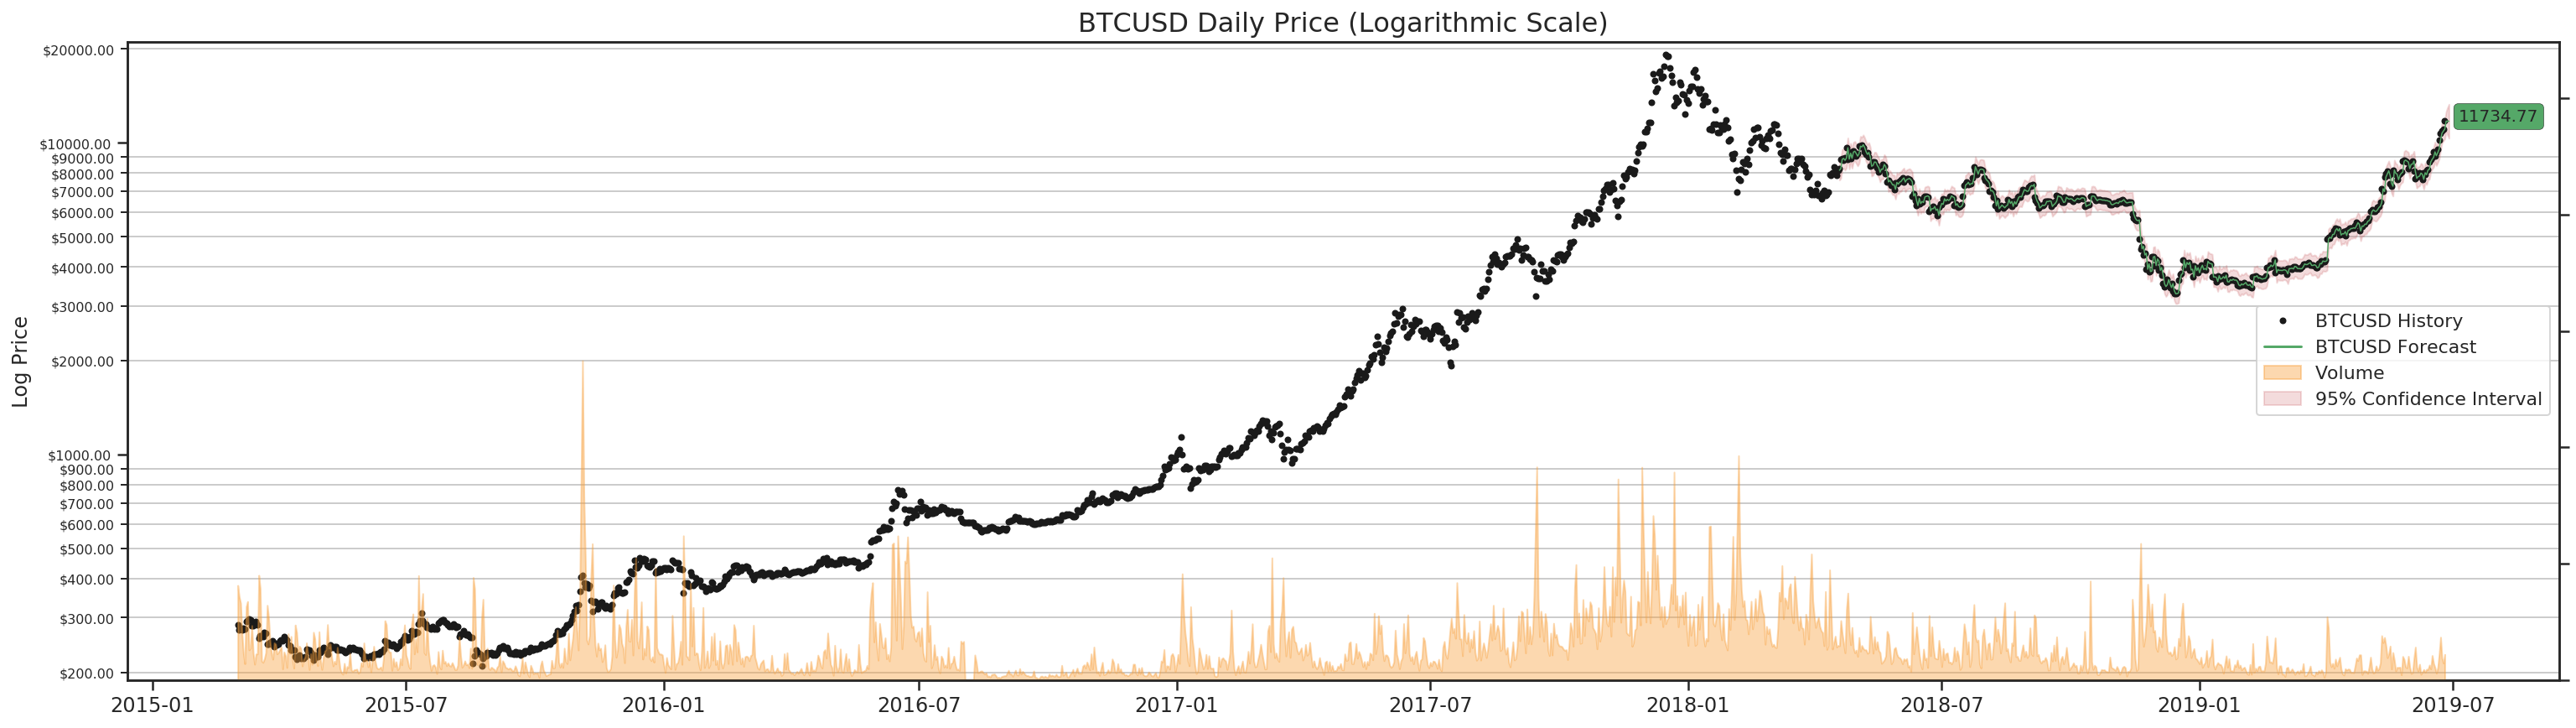

BTCUSD Weekly 1st Order Differencing Best (p, d, q):
AIC best param: (1, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)


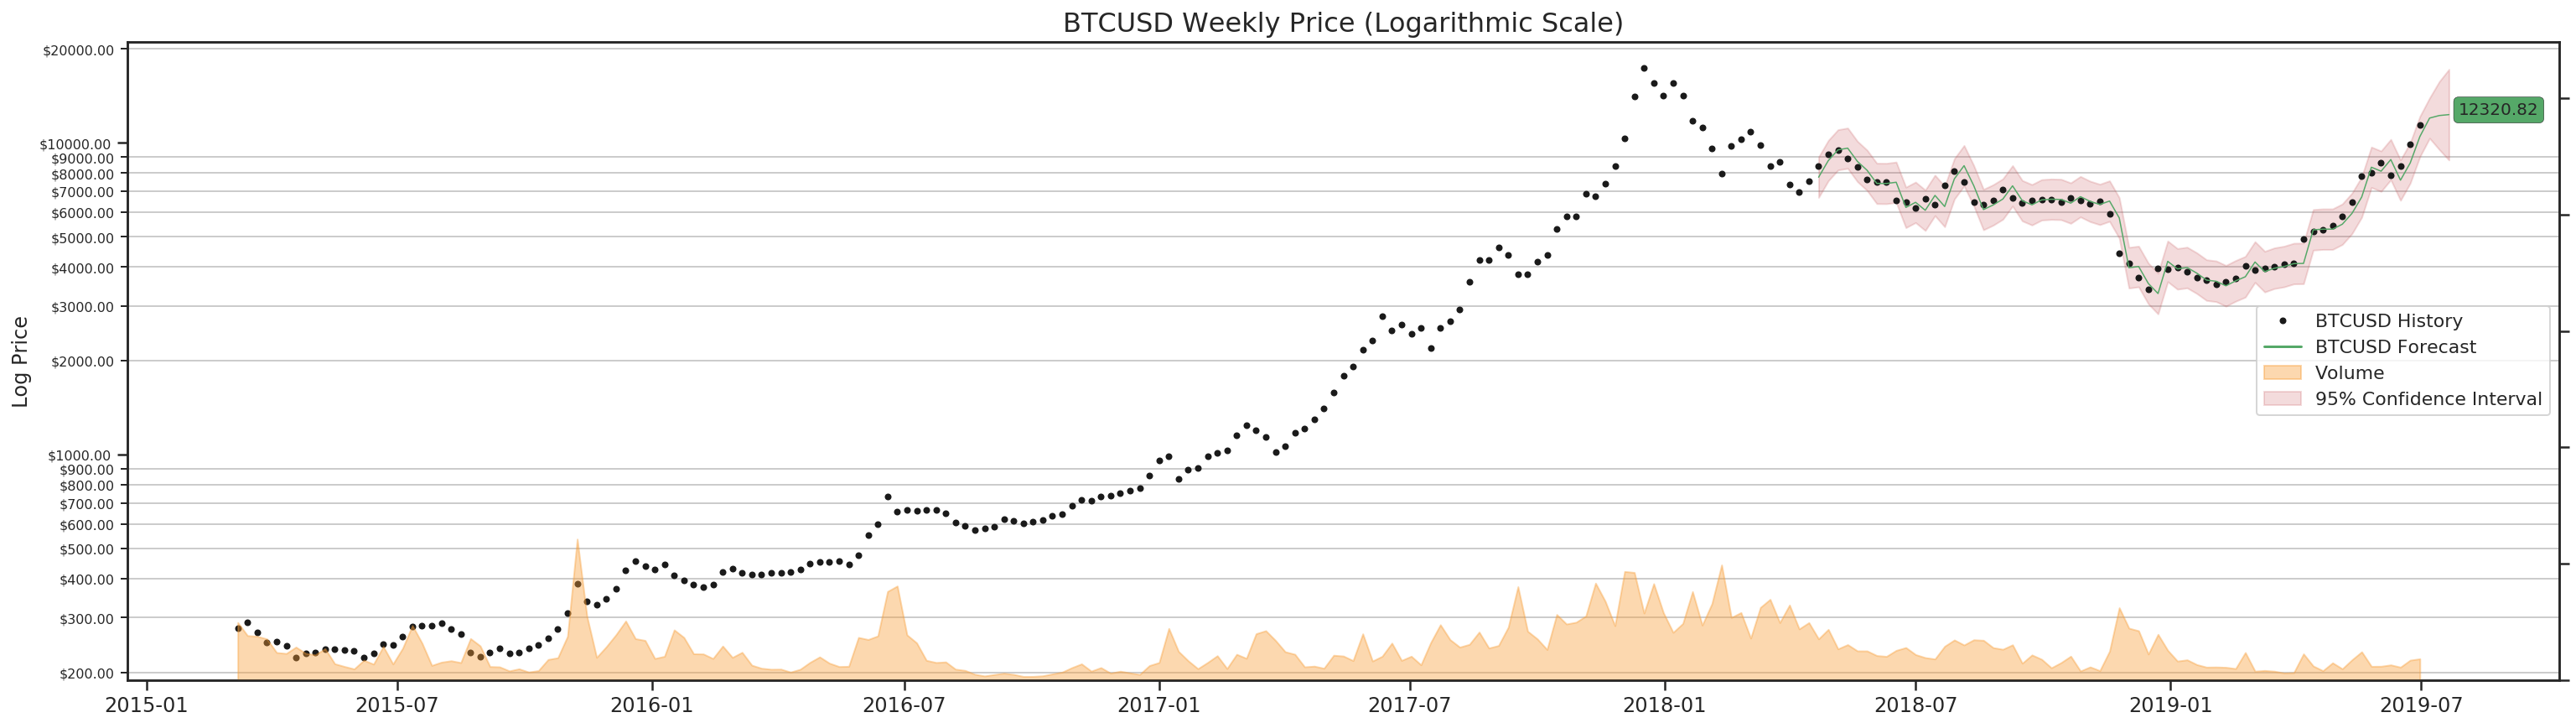

BTCUSD Bi-weekly 1st Order Differencing Best (p, d, q):
AIC best param: (0, 1, 1)
BIC best param: (0, 1, 1)
HQIC best param: (0, 1, 1)
Best Param Selected: (0, 1, 1)


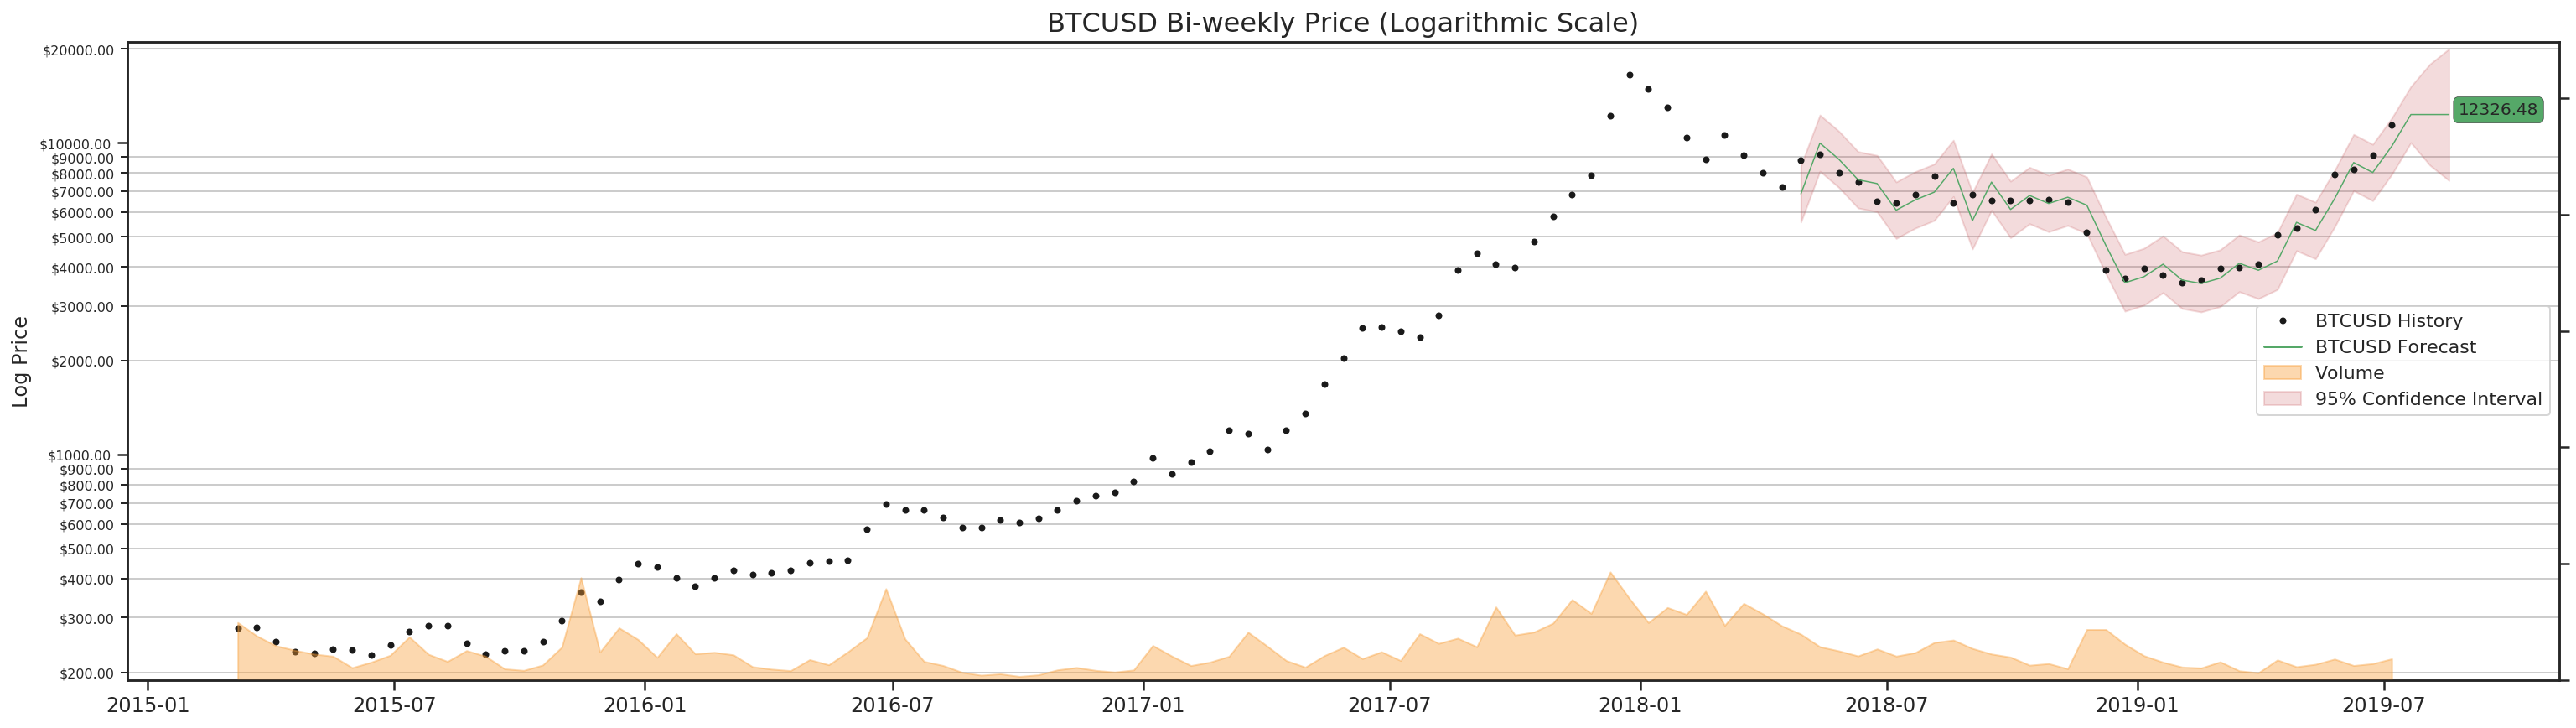

BTCUSD Monthly 1st Order Differencing Best (p, d, q):
AIC best param: (1, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)


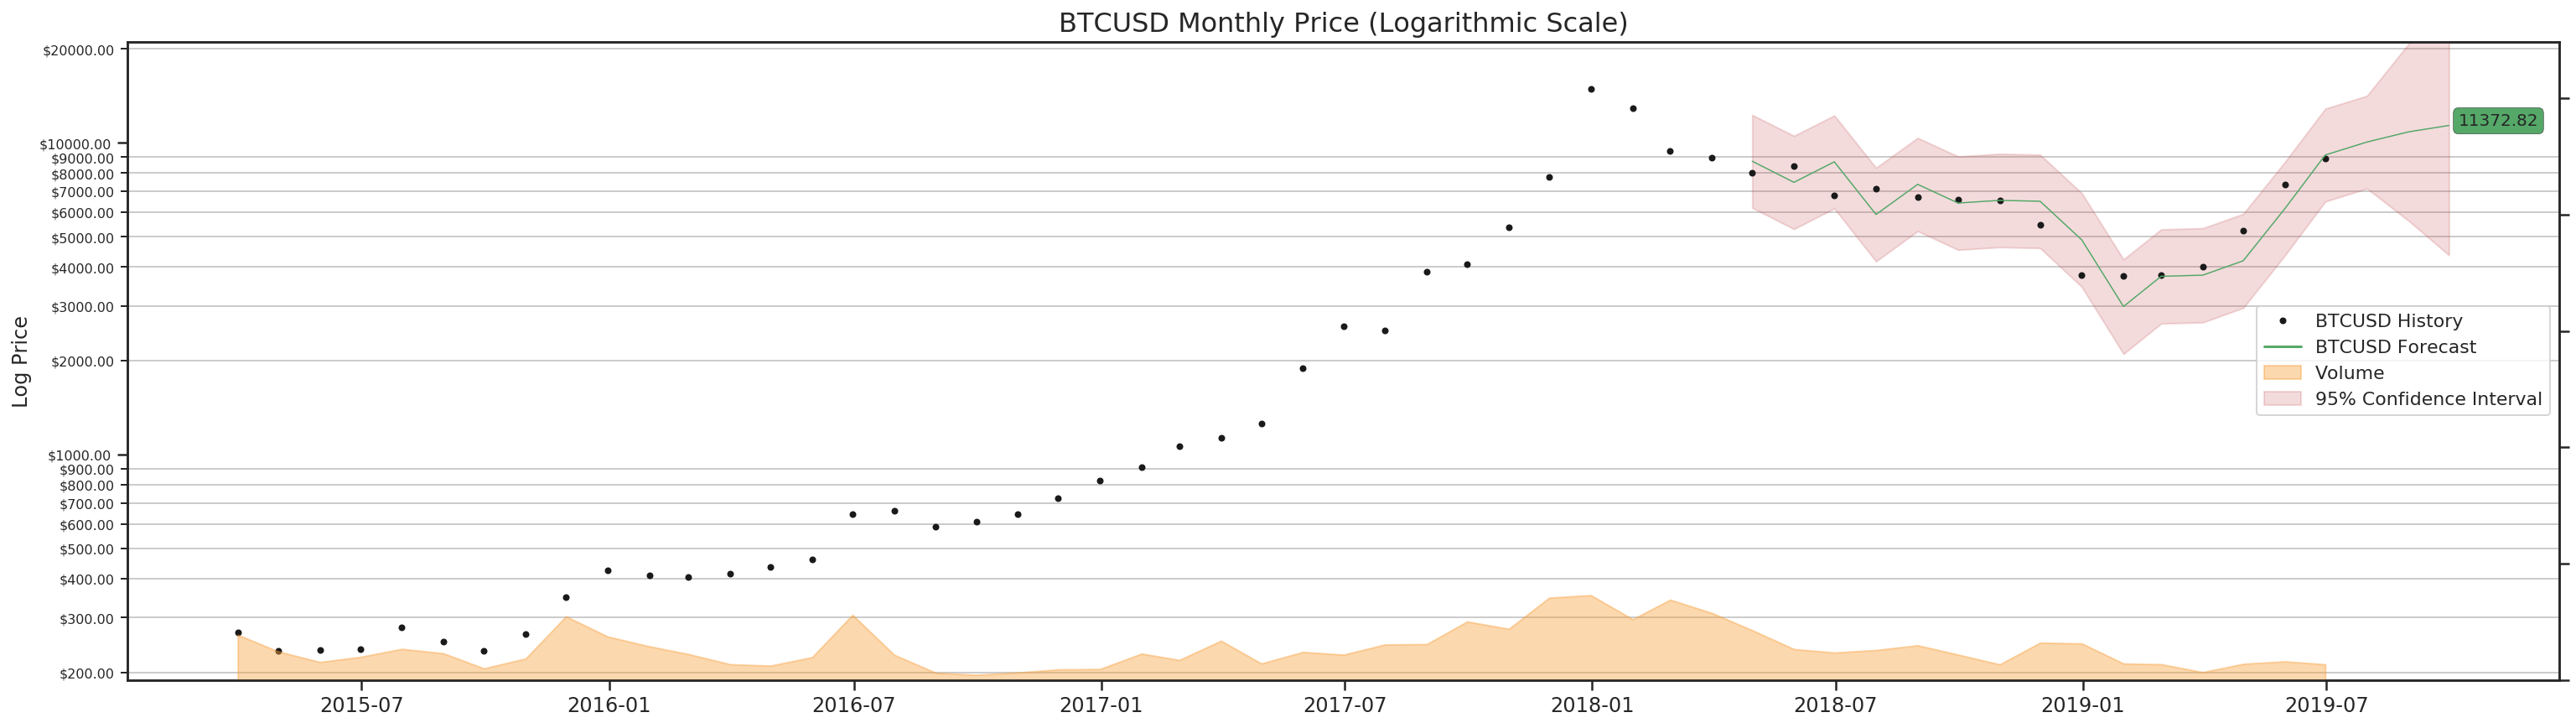

In [135]:
for df in df_list:
    render_results(df)

As mentioned earlier, we can try a different params combination for daily data.
```python
render_results(d_df, params=(6, 1, 0))
```

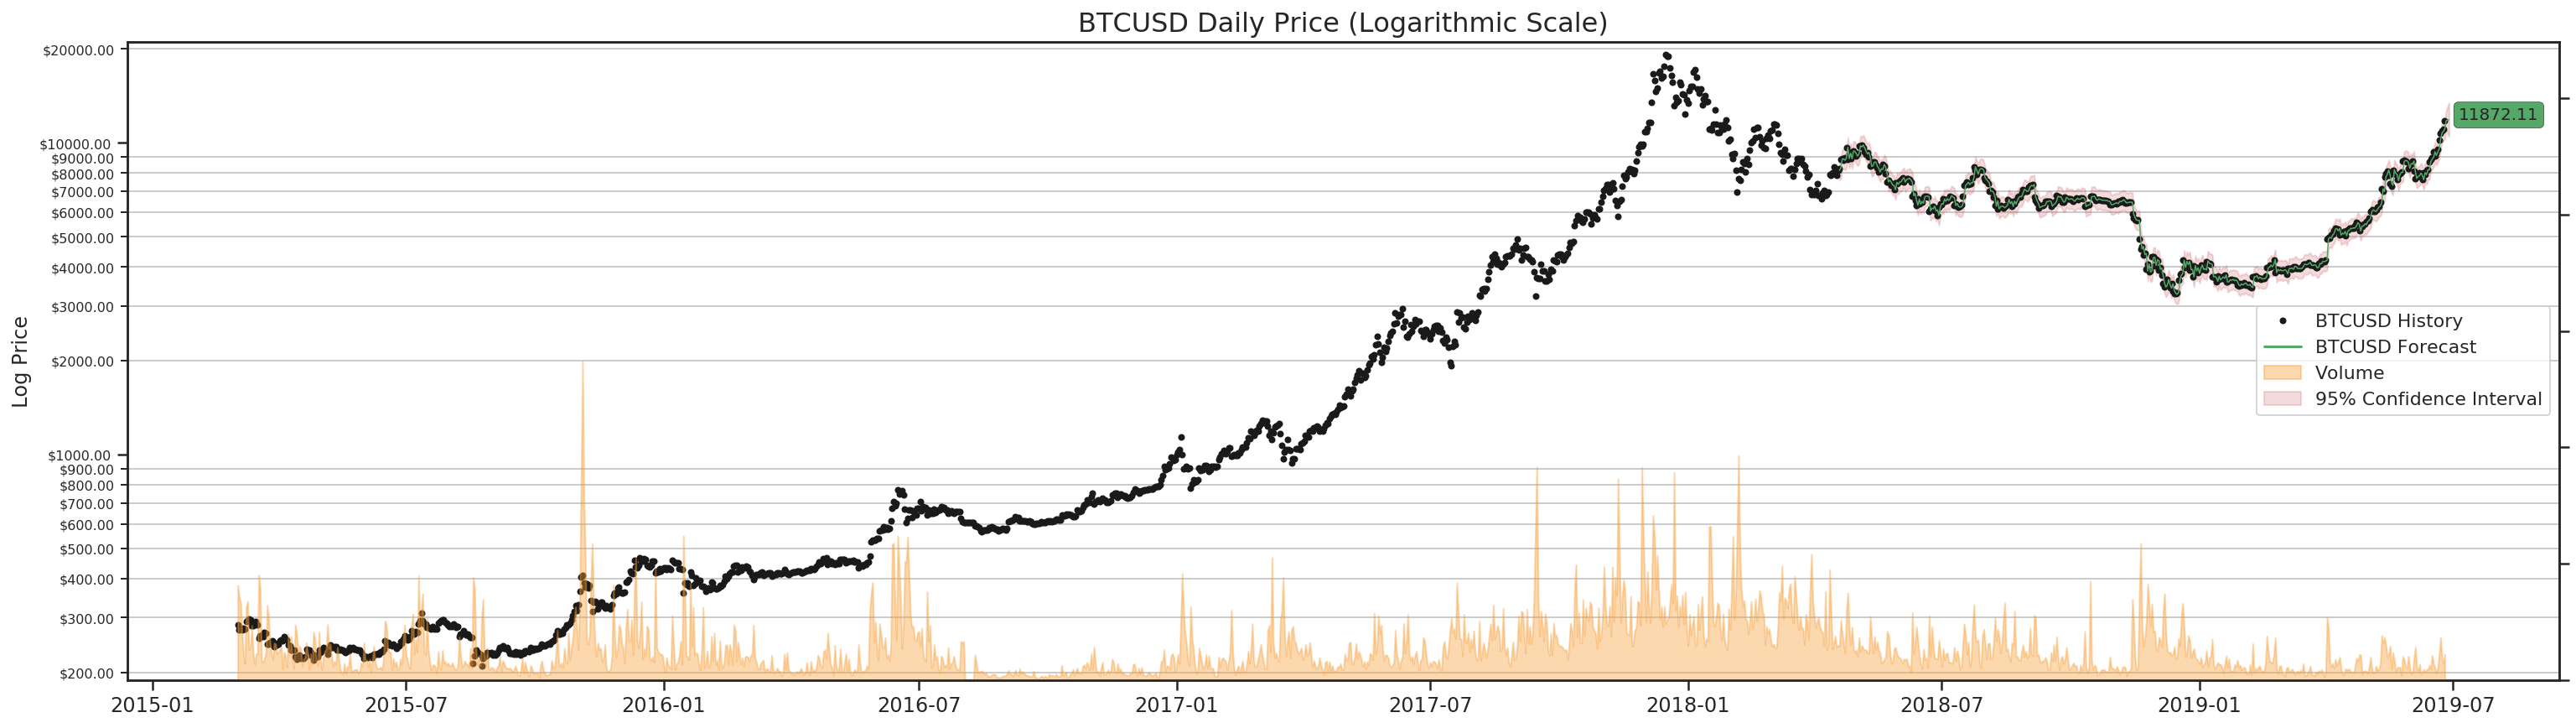

In [136]:
render_results(d_df, params=(6, 1, 0))

I wish our results could be more accurate. Oh, well...

This might be the end of our series. We could explore a bit further by incoporating the seasonality into our model, and I will see if I can put up another post on that topic in the near future. I hope you have enjoyed this series, and please do not forget to check out [our quant channel](https://discord.gg/jchMcc2). Feel free to shoot me a message if you have any questions/comments/proposals. Ciao!  